# Forecasting total weekly Walmart sales with Linear Regression from Scratch

The purpose of this notebook is to predict Walmart sales using linear regression models generated using numpy only (no ready-made Linear Regression models used). This is in order to more fully understand Linear Regression, how Linear Regression models are built, trained and used to generate predications.

The Walmart historical sales data is found on Kaggle here: https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data

Using the historical sales data for 45 Walmart stores located in different regions, this project will involve building a Linear Regression model from scratch to predict weekly total sales for stores.

The data  from Kaggle includes:

`stores.csv`: This contains anonymised information about the 45 stores, indicating the type and size of store.

`train.csv`: This is the historical training data, which covers from 2010-02-05 to 2012-11-01. Within this file are the following fields:

    Store - the store number
    Dept - the department number
    Date - the week
    Weekly_Sales -  sales for the given department in the given store
    IsHoliday - whether the week is a special holiday week

`features.csv`: This  contains additional data related to the store, department, and regional activity for the given dates. It contains the following fields:

    Store - the store number
    Date - the week
    Temperature - average temperature in the region
    Fuel_Price - cost of fuel in the region
    MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.
    CPI - the consumer price index
    Unemployment - the unemployment rate
    IsHoliday - whether the week is a special holiday week


In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
from sklearn import linear_model
from sklearn import metrics
import seaborn as sns
sns.set_style("whitegrid")
from sklearn.model_selection import train_test_split

## Data preparation

In [2]:
train = pd.read_csv('train.csv')
stores = pd.read_csv('stores.csv')
features = pd.read_csv('features.csv')

In [3]:
train.head()

Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False

In [4]:
features.tail()

Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
8185     45  2013-06-28        76.05       3.639    4842.29     975.03   
8186     45  2013-07-05        77.50       3.614    9090.48    2268.58   
8187     45  2013-07-12        79.37       3.614    3789.94    1827.31   
8188     45  2013-07-19        82.84       3.737    2961.49    1047.07   
8189     45  2013-07-26        76.06       3.804     212.02     851.73   

      MarkDown3  MarkDown4  MarkDown5  CPI  Unemployment  IsHoliday  
8185       3.00    2449.97    3169.69  NaN           NaN      False  
8186     582.74    5797.47    1514.93  NaN           NaN      False  
8187      85.72     744.84    2150.36  NaN           NaN      False  
8188     204.19     363.00    1059.46  NaN           NaN      False  
8189       2.06      10.88    1864.57  NaN           NaN      False

In [5]:
stores.head()

Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875

In [6]:
#merge train and feature dfs on store and date and is holiday
df_merged = pd.merge(train, features, on=['Store','Date','IsHoliday'], how='inner')

In [7]:
#merge merged and stores dfs on store
df_merged = pd.merge(df_merged, stores, on=['Store'], how='inner')

In [8]:
df_merged.head()

Store  Dept        Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1  2010-02-05      24924.50      False        42.31       2.572   
1      1     2  2010-02-05      50605.27      False        42.31       2.572   
2      1     3  2010-02-05      13740.12      False        42.31       2.572   
3      1     4  2010-02-05      39954.04      False        42.31       2.572   
4      1     5  2010-02-05      32229.38      False        42.31       2.572   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        NaN        NaN        NaN        NaN        NaN  211.096358   
1        NaN        NaN        NaN        NaN        NaN  211.096358   
2        NaN        NaN        NaN        NaN        NaN  211.096358   
3        NaN        NaN        NaN        NaN        NaN  211.096358   
4        NaN        NaN        NaN        NaN        NaN  211.096358   

   Unemployment Type    Size  
0         8.106    A  151315  
1         8.106    A  151315  
2         8.106    A  151315  
3         8.106    A  151315  
4         8.106    A  151315

In [9]:
df_merged.Dept.nunique()

81

In [10]:
df_merged.describe().transpose()

count           mean           std        min           25%  \
Store         421570.0      22.200546     12.785297      1.000     11.000000   
Dept          421570.0      44.260317     30.492054      1.000     18.000000   
Weekly_Sales  421570.0   15981.258123  22711.183519  -4988.940   2079.650000   
Temperature   421570.0      60.090059     18.447931     -2.060     46.680000   
Fuel_Price    421570.0       3.361027      0.458515      2.472      2.933000   
MarkDown1     150681.0    7246.420196   8291.221345      0.270   2240.270000   
MarkDown2     111248.0    3334.628621   9475.357325   -265.760     41.600000   
MarkDown3     137091.0    1439.421384   9623.078290    -29.100      5.080000   
MarkDown4     134967.0    3383.168256   6292.384031      0.220    504.220000   
MarkDown5     151432.0    4628.975079   5962.887455    135.160   1878.440000   
CPI           421570.0     171.201947     39.159276    126.064    132.022667   
Unemployment  421570.0       7.960289      1.863296      3.879      6.891000   
Size          421570.0  136727.915739  60980.583328  34875.000  93638.000000   

                       50%            75%            max  
Store             22.00000      33.000000      45.000000  
Dept              37.00000      74.000000      99.000000  
Weekly_Sales    7612.03000   20205.852500  693099.360000  
Temperature       62.09000      74.280000     100.140000  
Fuel_Price         3.45200       3.738000       4.468000  
MarkDown1       5347.45000    9210.900000   88646.760000  
MarkDown2        192.00000    1926.940000  104519.540000  
MarkDown3         24.60000     103.990000  141630.610000  
MarkDown4       1481.31000    3595.040000   67474.850000  
MarkDown5       3359.45000    5563.800000  108519.280000  
CPI              182.31878     212.416993     227.232807  
Unemployment       7.86600       8.572000      14.313000  
Size          140167.00000  202505.000000  219622.000000

In [11]:
df_merged.dtypes

Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
Type             object
Size              int64
dtype: object

In [12]:
#create column where date converted into datetime object
from datetime import datetime as dt

In [13]:
df_merged['DateTime']=[dt.strptime(x,'%Y-%m-%d') for x in list(df_merged['Date'])]
df_merged['DateTime'].head()

0   2010-02-05
1   2010-02-05
2   2010-02-05
3   2010-02-05
4   2010-02-05
Name: DateTime, dtype: datetime64[ns]

In [14]:
df_merged.head()

Store  Dept        Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1  2010-02-05      24924.50      False        42.31       2.572   
1      1     2  2010-02-05      50605.27      False        42.31       2.572   
2      1     3  2010-02-05      13740.12      False        42.31       2.572   
3      1     4  2010-02-05      39954.04      False        42.31       2.572   
4      1     5  2010-02-05      32229.38      False        42.31       2.572   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        NaN        NaN        NaN        NaN        NaN  211.096358   
1        NaN        NaN        NaN        NaN        NaN  211.096358   
2        NaN        NaN        NaN        NaN        NaN  211.096358   
3        NaN        NaN        NaN        NaN        NaN  211.096358   
4        NaN        NaN        NaN        NaN        NaN  211.096358   

   Unemployment Type    Size   DateTime  
0         8.106    A  151315 2010-02-05  
1         8.106    A  151315 2010-02-05  
2         8.106    A  151315 2010-02-05  
3         8.106    A  151315 2010-02-05  
4         8.106    A  151315 2010-02-05

## Data Exploration and Pre-Processing

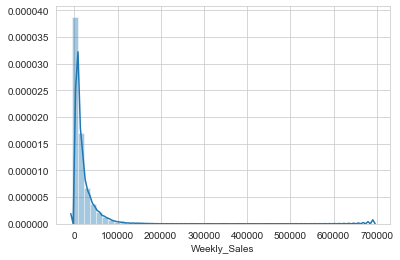

In [15]:
sns.distplot(df_merged['Weekly_Sales'])

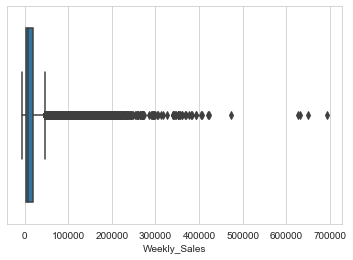

In [16]:
sns.boxplot(df_merged['Weekly_Sales'])

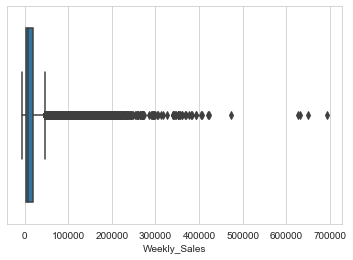

In [17]:
sns.boxplot(df_merged['Weekly_Sales'])

In [18]:
#clip weekly sales 0, 400,000
df_merged['Weekly_Sales'] = df_merged['Weekly_Sales'].clip(0,400000)

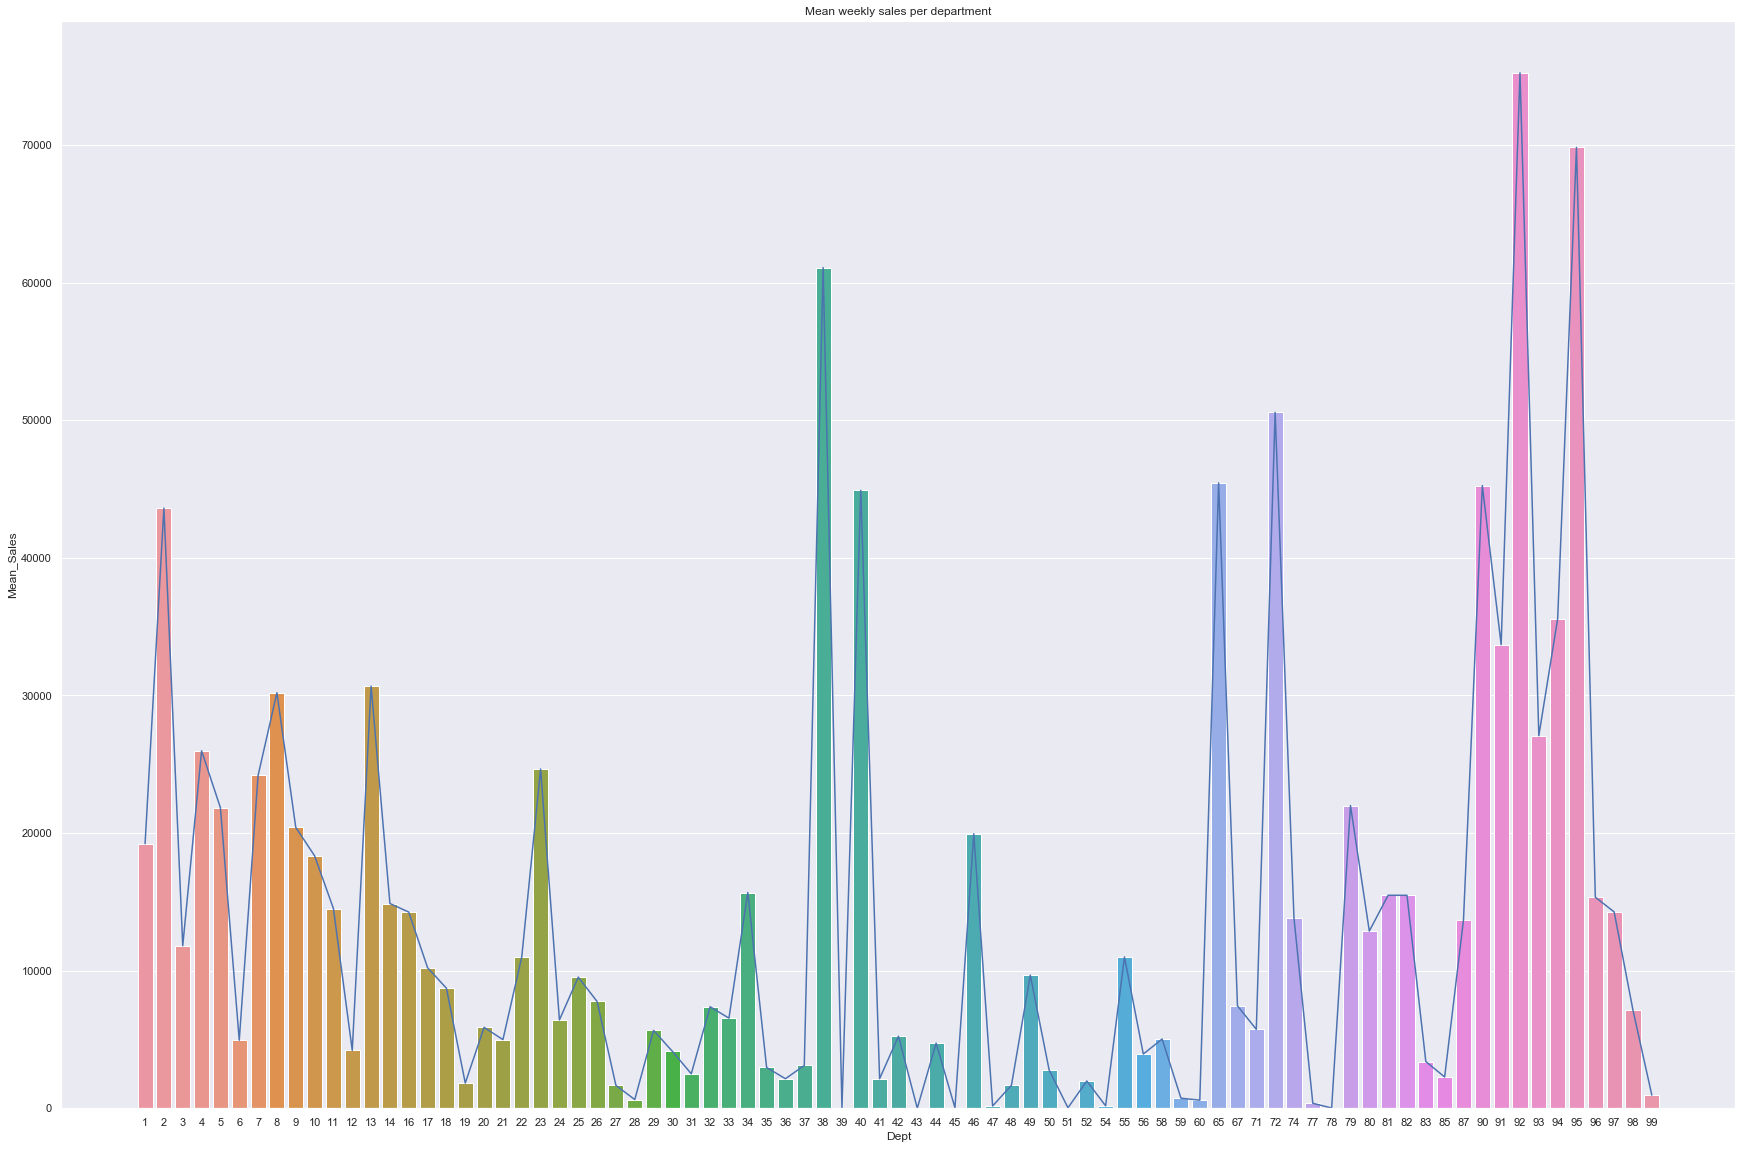

In [19]:
#mean weekly sales per dept
sns.set(rc={'figure.figsize':(30, 20)})
dept_df = pd.DataFrame(df_merged[['Dept','Weekly_Sales']].drop_duplicates().groupby('Dept').mean()).reset_index()
dept_df.columns = ['Dept', 'Mean_Sales']
sns.barplot(x ='Dept', y='Mean_Sales', data=dept_df);
plt.plot(dept_df['Mean_Sales']);
plt.title('Mean weekly sales per department')
del dept_df

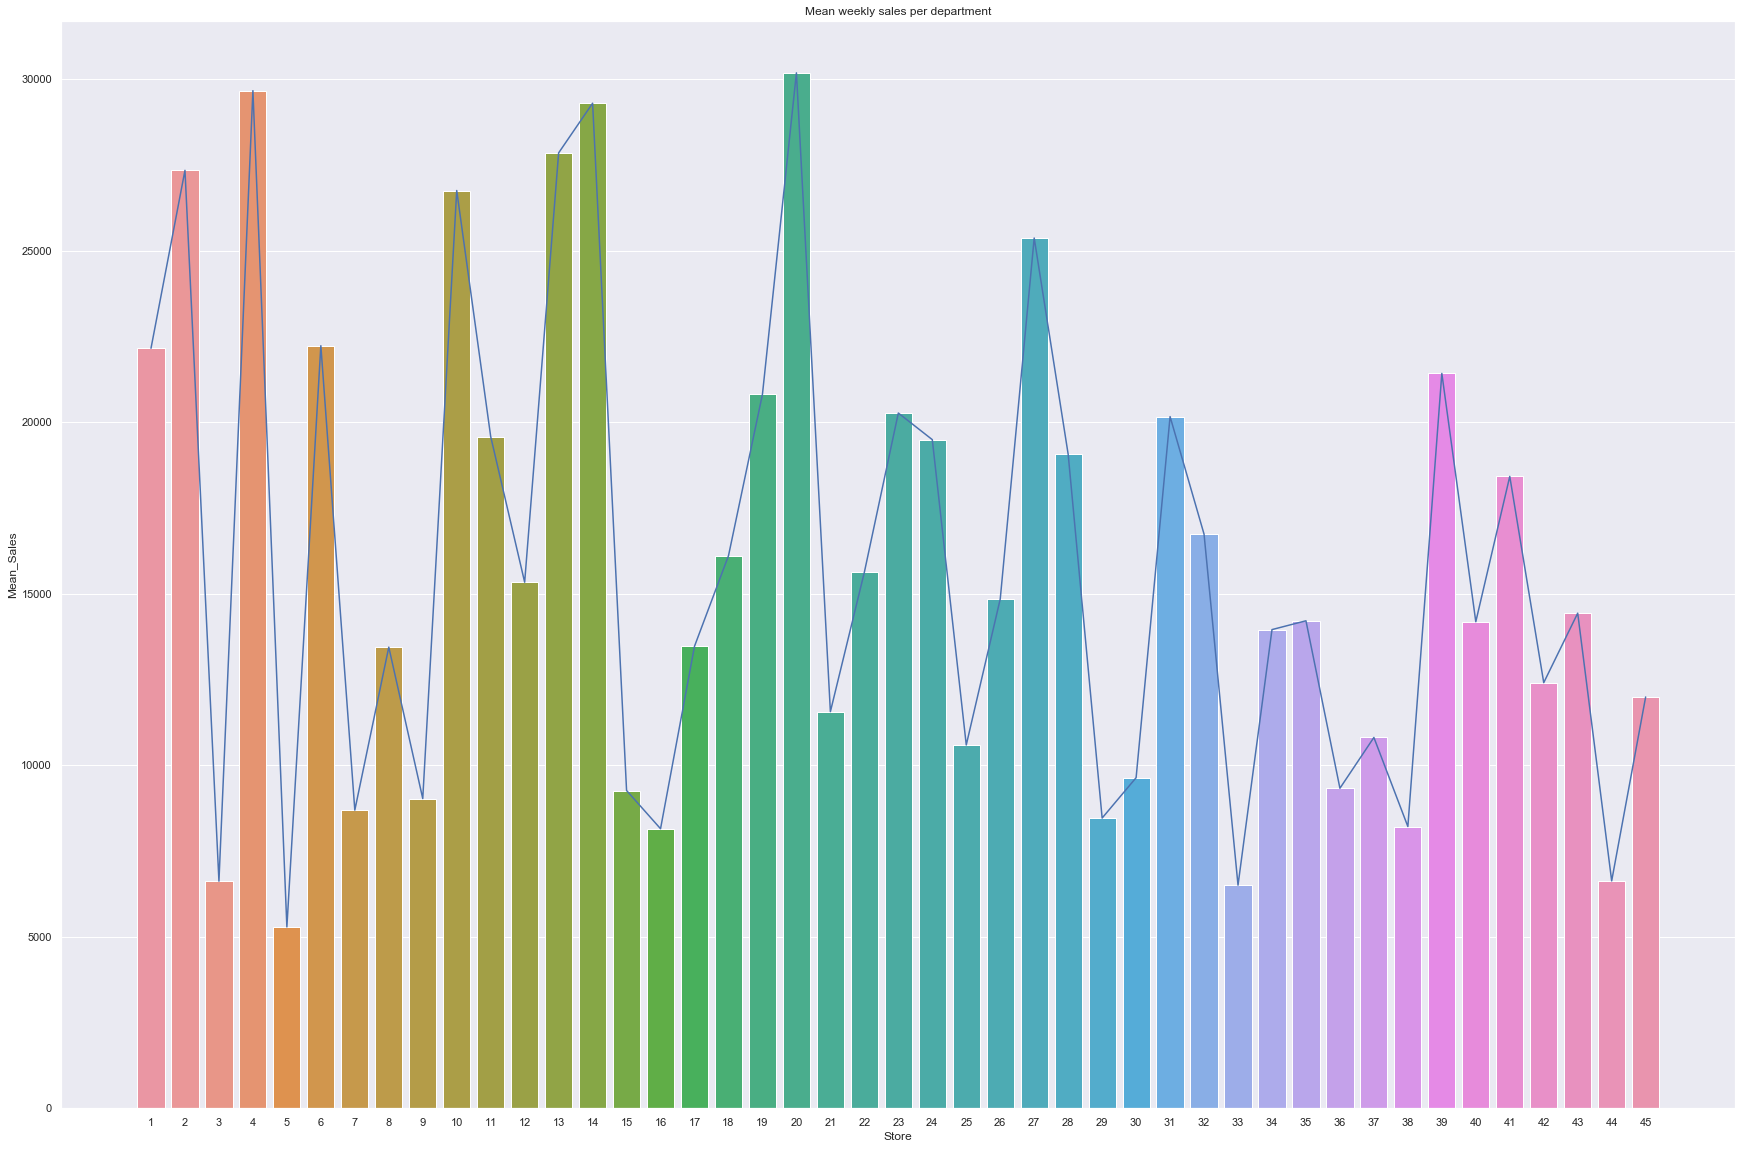

In [20]:
#mean weekly sales per store
sns.set(rc={'figure.figsize':(30, 20)})
store_df = pd.DataFrame(df_merged[['Store','Weekly_Sales']].drop_duplicates().groupby('Store').mean()).reset_index()
store_df.columns = ['Store', 'Mean_Sales']
sns.barplot(x ='Store', y='Mean_Sales', data=store_df);
plt.plot(store_df['Mean_Sales']);
plt.title('Mean weekly sales per department')
del store_df

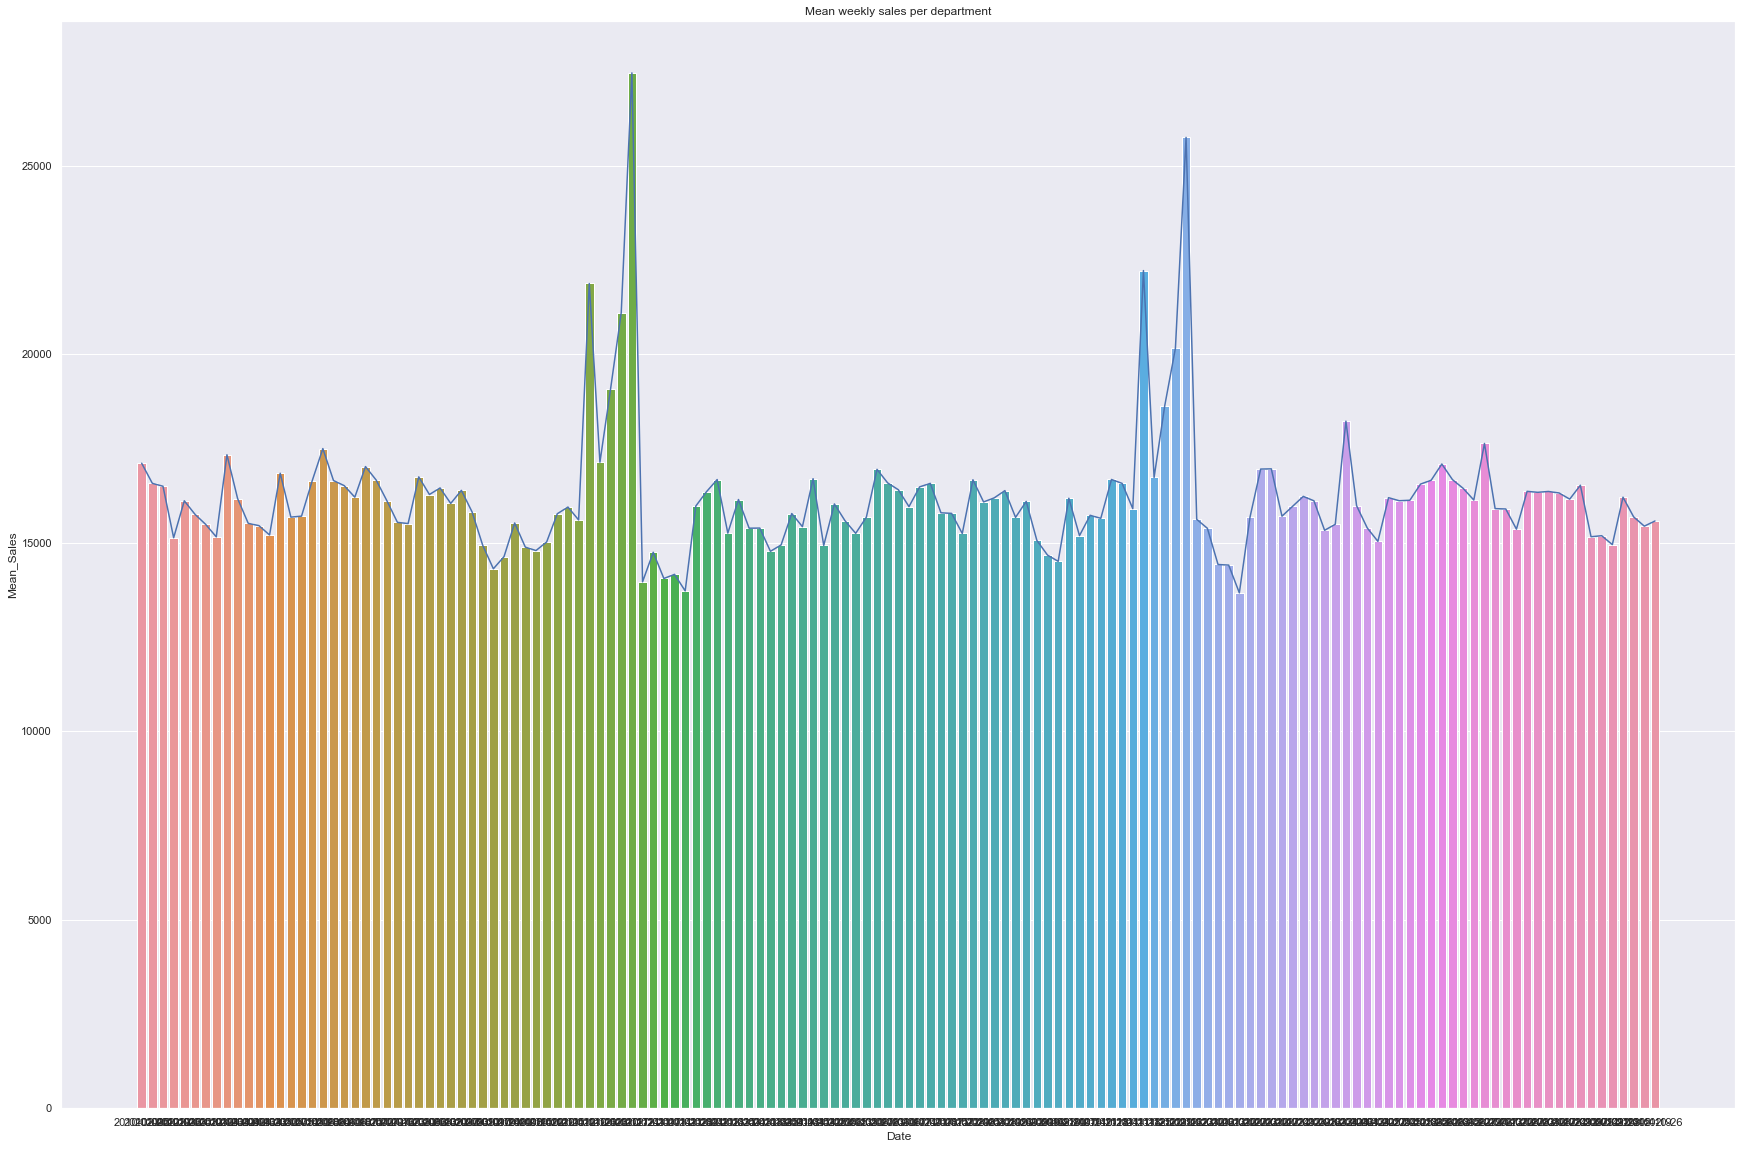

In [21]:
#mean weekly sales 
sns.set(rc={'figure.figsize':(30, 20)})
date_df = pd.DataFrame(df_merged[['Date','Weekly_Sales']].drop_duplicates().groupby('Date').mean()).reset_index()
date_df.columns = ['Date', 'Mean_Sales']
sns.barplot(x ='Date', y='Mean_Sales', data=date_df);
plt.plot(date_df['Mean_Sales']);
plt.title('Mean weekly sales per department')
del date_df

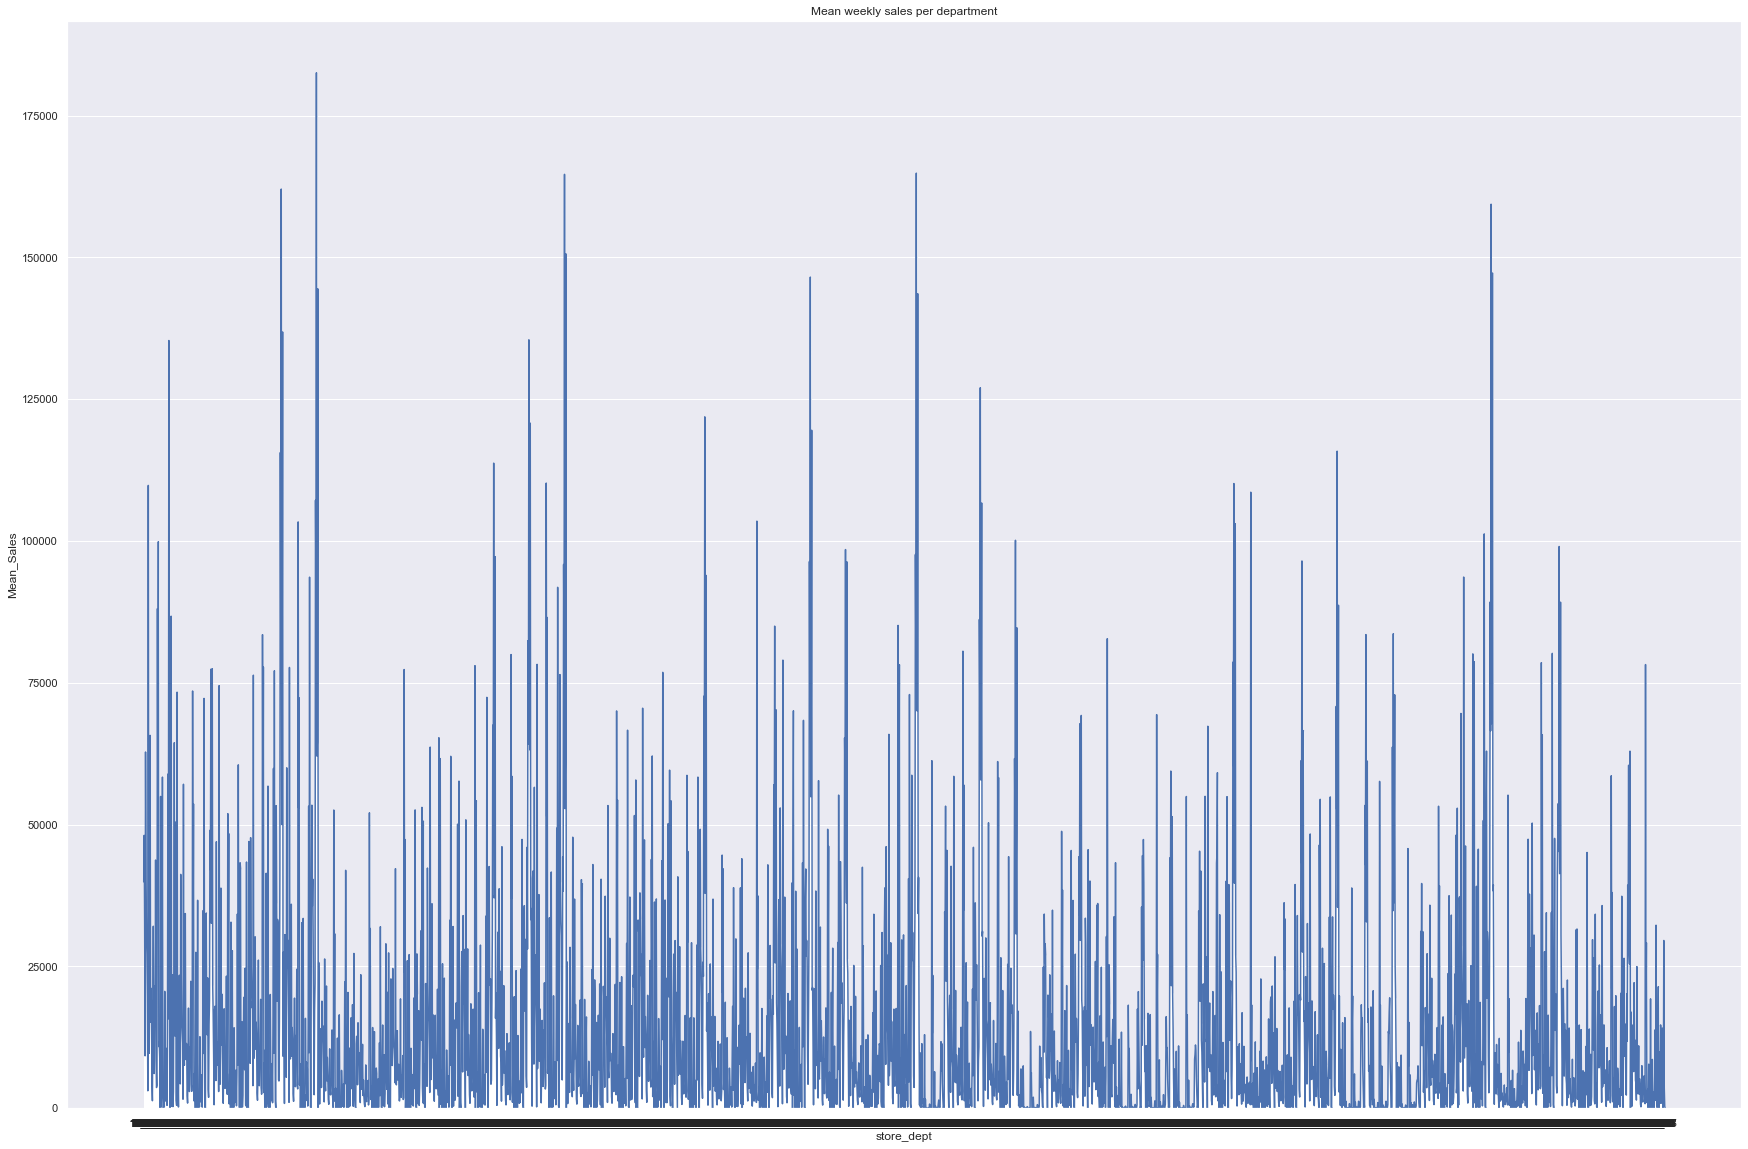

In [22]:
#mean weekly sales per store-dept
sns.set(rc={'figure.figsize':(30, 20)})
date_df = pd.DataFrame(df_merged[['Store','Dept','Weekly_Sales']].drop_duplicates())
date_df['store_dept'] = date_df['Store'].astype(str) + "_" + date_df['Dept'].astype(str)       
date_df = date_df.drop(['Store','Dept'], axis=1)
date_df = date_df.groupby('store_dept').mean().reset_index()
date_df.columns = ['store_dept', 'Mean_Sales']
sns.barplot(x ='store_dept', y='Mean_Sales', data=date_df);
plt.plot(date_df['Mean_Sales']);
plt.title('Mean weekly sales per department')
del date_df

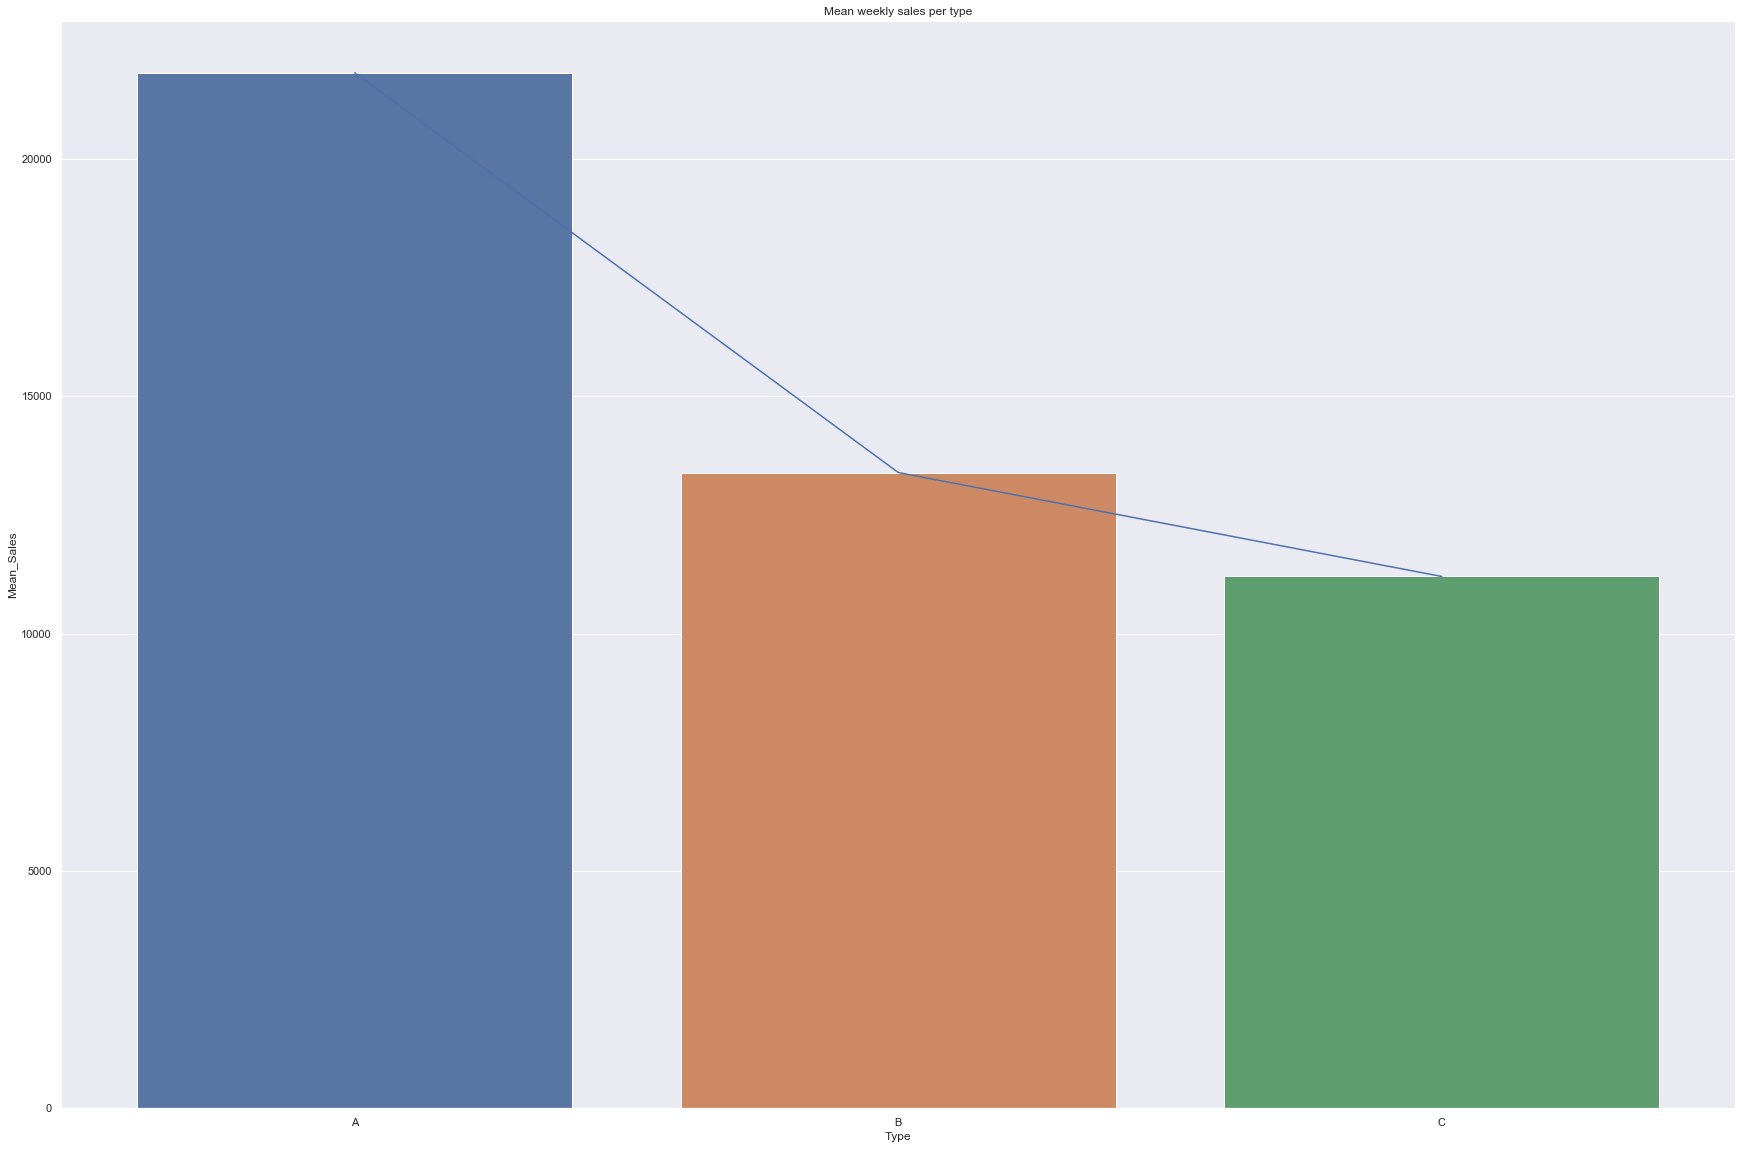

In [23]:
#mean weekly sales by type
sns.set(rc={'figure.figsize':(30, 20)})
type_df = pd.DataFrame(df_merged[['Type','Weekly_Sales']].drop_duplicates().groupby('Type').mean()).reset_index()
type_df.columns = ['Type', 'Mean_Sales']
sns.barplot(x ='Type', y='Mean_Sales', data=type_df);
plt.plot(type_df['Mean_Sales']);
plt.title('Mean weekly sales per type')
del type_df

There appears to be a relationship between store type and sales.

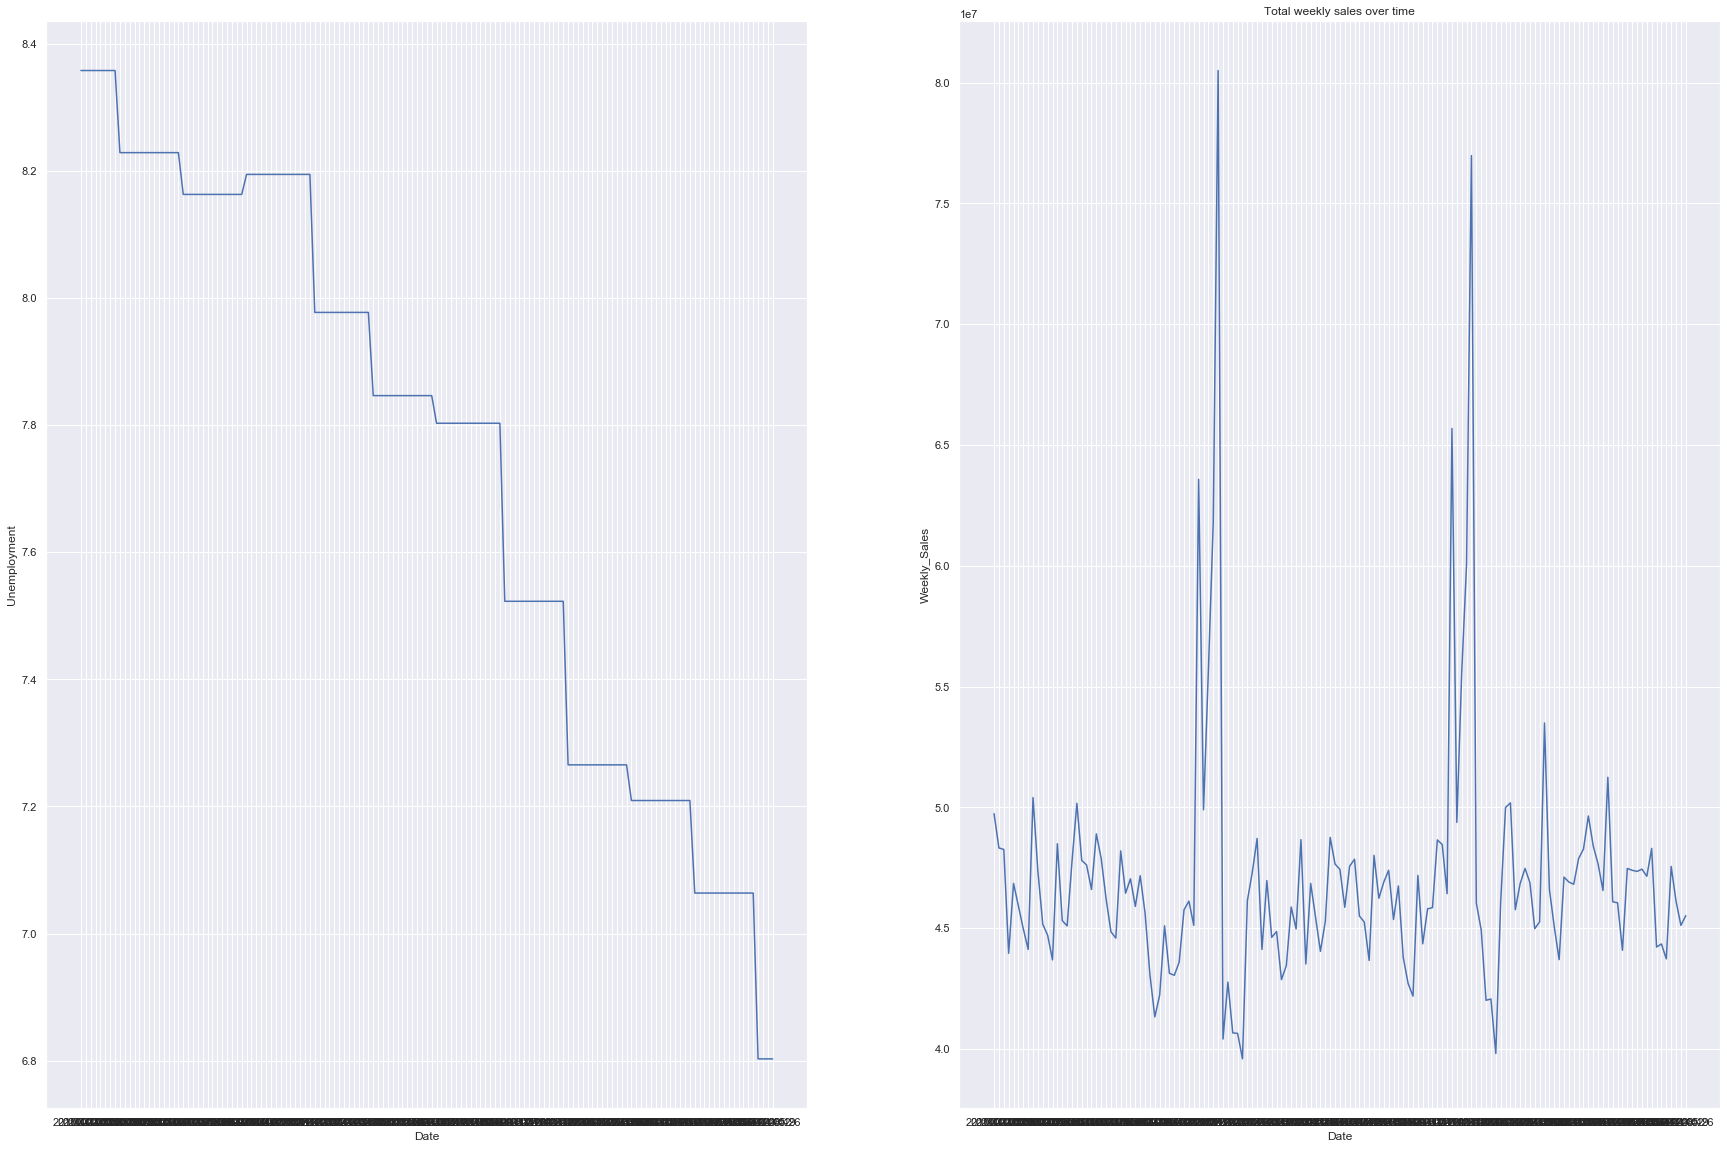

In [24]:
#mean weekly sales by type
sns.set(rc={'figure.figsize':(30, 20)})
unemp_df = pd.DataFrame(df_merged[['Date','Unemployment']].drop_duplicates().groupby('Date').mean()).reset_index()
unemp_df.columns = ['Date', 'Unemployment']
sales_df = pd.DataFrame(df_merged[['Date','Weekly_Sales']].drop_duplicates().groupby('Date').sum()).reset_index()
sales_df.columns = ['Date', 'Weekly_Sales']

f, axes = plt.subplots(1, 2)
sns.lineplot(x ='Date', y='Unemployment', data=unemp_df, ax=axes[0]);
plt.title('Mean unemployment over time')
sns.lineplot(x ='Date', y='Weekly_Sales', data=sales_df, ax=axes[1]);
plt.title('Total weekly sales over time')
del unemp_df, sales_df

There does not appear to be any link between unemployment and weekly sales.

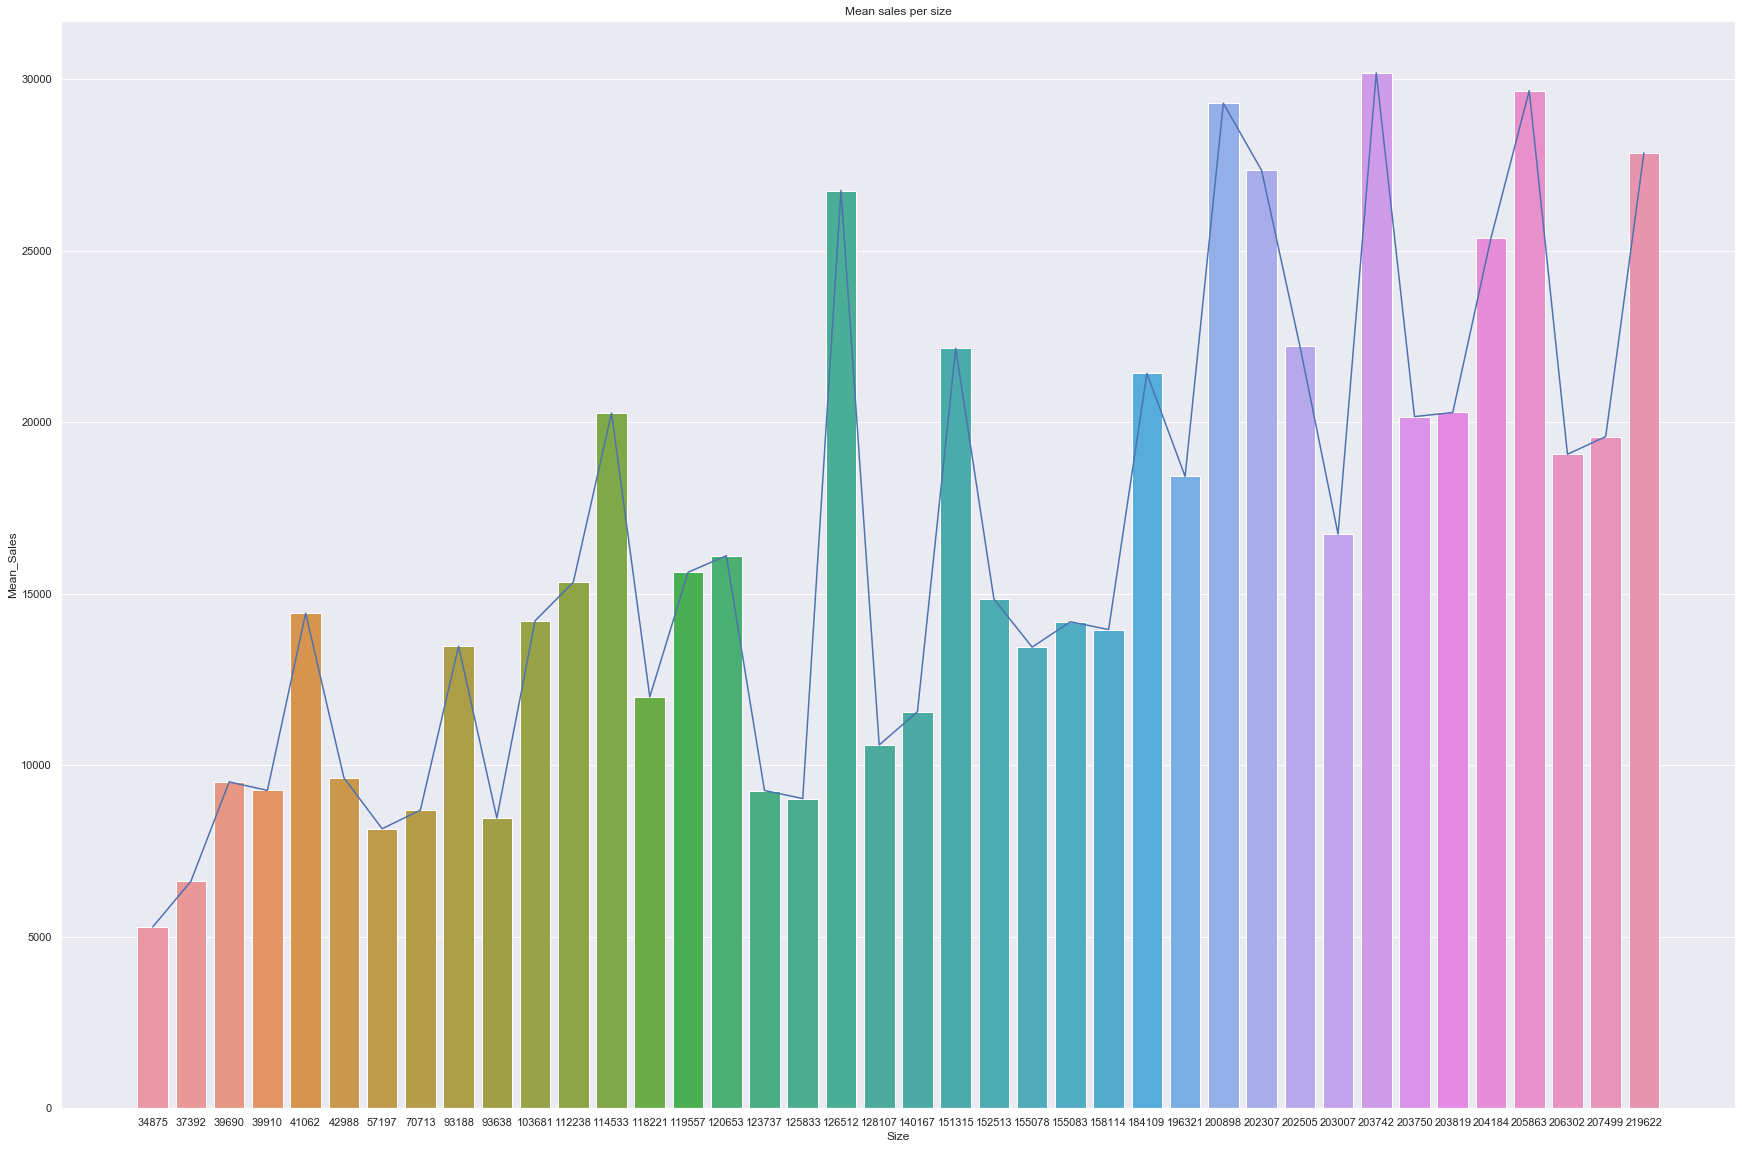

In [25]:
#mean weekly sales by type
sns.set(rc={'figure.figsize':(30, 20)})
size_df = pd.DataFrame(df_merged[['Size','Weekly_Sales']].drop_duplicates().groupby('Size').mean()).reset_index()
size_df.columns = ['Size', 'Mean_Sales']
sns.barplot(x ='Size', y='Mean_Sales', data=size_df);
plt.plot(size_df['Mean_Sales']);
plt.title('Mean sales per size')
del size_df

Size does appear to be associated with different levels of sales.

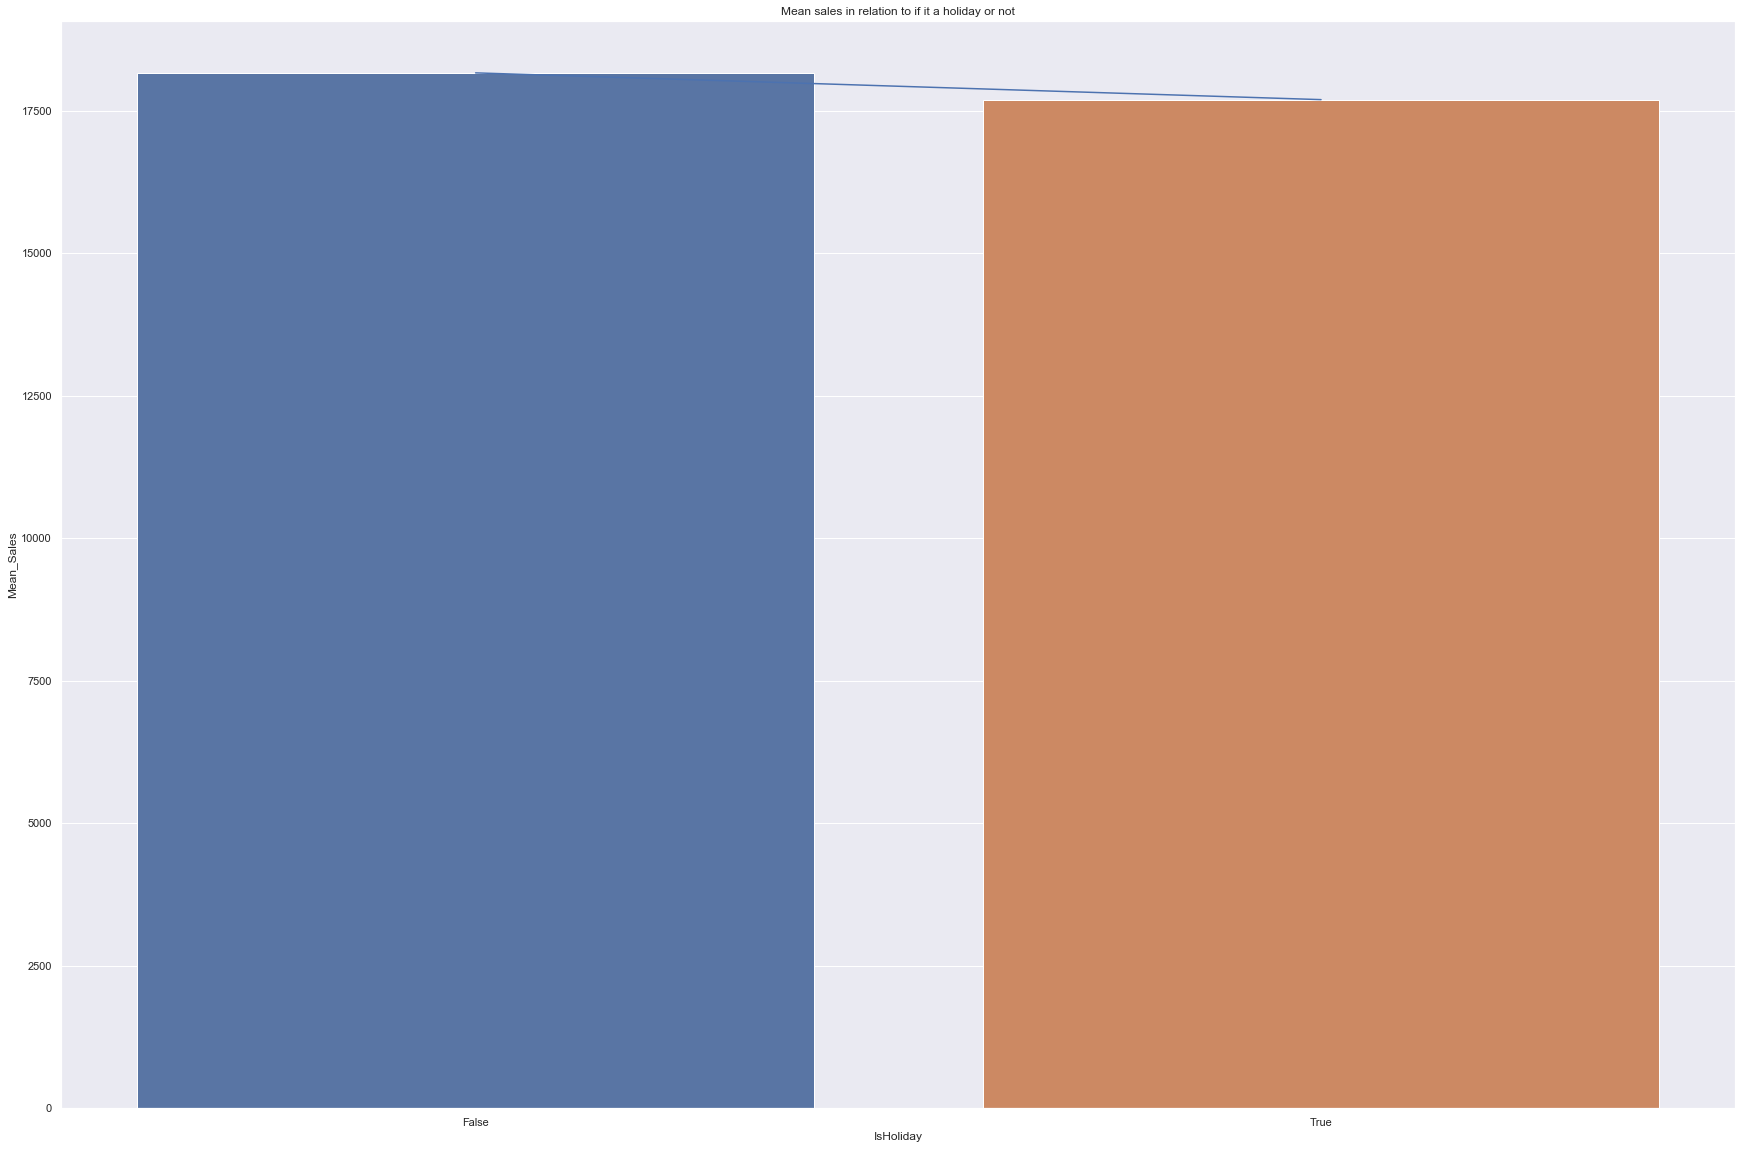

In [26]:
#mean weekly sales by type
sns.set(rc={'figure.figsize':(30, 20)})
hol_df = pd.DataFrame(df_merged[['IsHoliday','Weekly_Sales']].drop_duplicates().groupby('IsHoliday').mean()).reset_index()
hol_df.columns = ['IsHoliday', 'Mean_Sales']
sns.barplot(x ='IsHoliday', y='Mean_Sales', data=hol_df);
plt.plot(hol_df['Mean_Sales']);
plt.title('Mean sales in relation to if it a holiday or not')
del hol_df

Whether it is a holiday or not appears to have a minimal impact on sales.

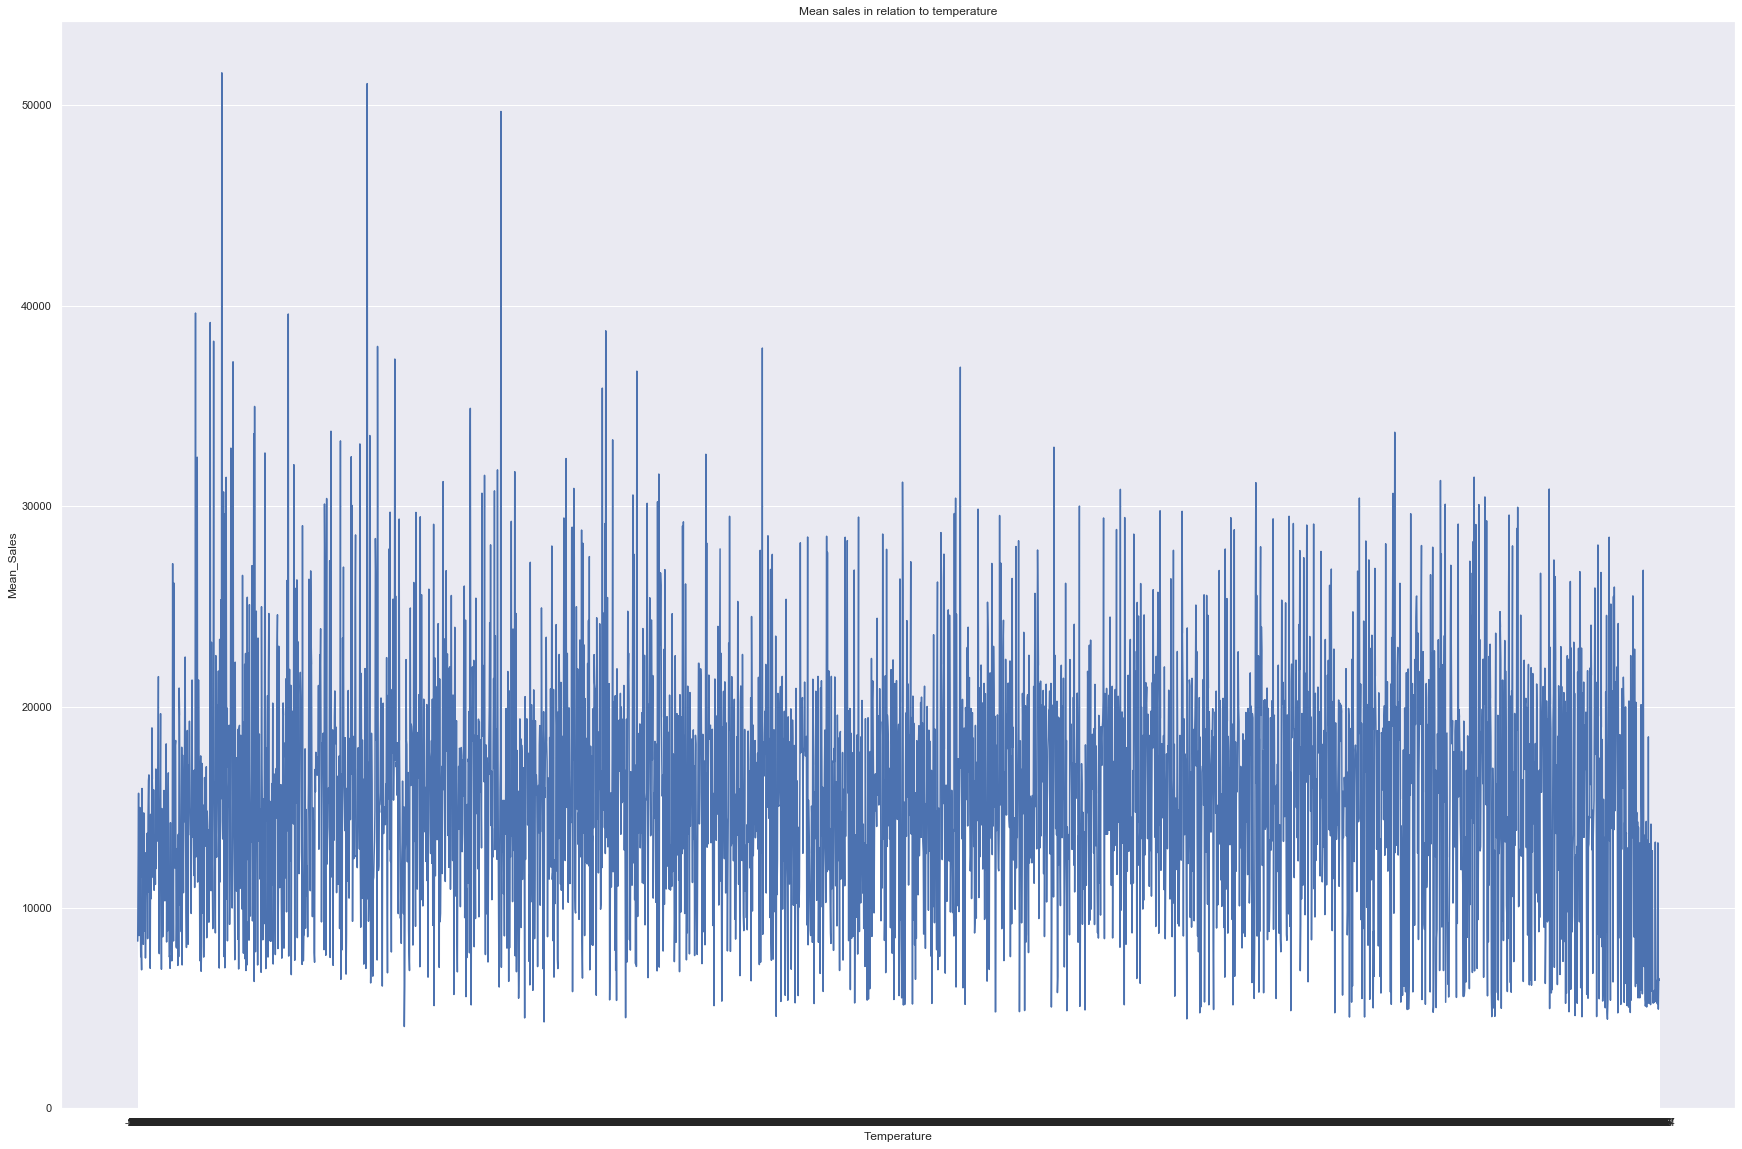

In [27]:
#mean weekly sales by type
sns.set(rc={'figure.figsize':(30, 20)})
temp_df = pd.DataFrame(df_merged[['Temperature','Weekly_Sales']].drop_duplicates().groupby('Temperature').mean()).reset_index()
temp_df.columns = ['Temperature', 'Mean_Sales']
sns.barplot(x ='Temperature', y='Mean_Sales', data=temp_df);
plt.plot(temp_df['Mean_Sales']);
plt.title('Mean sales in relation to temperature')
del temp_df

Temperature appears to have a minimal effect on sales, but mainly at the lower temperatures.

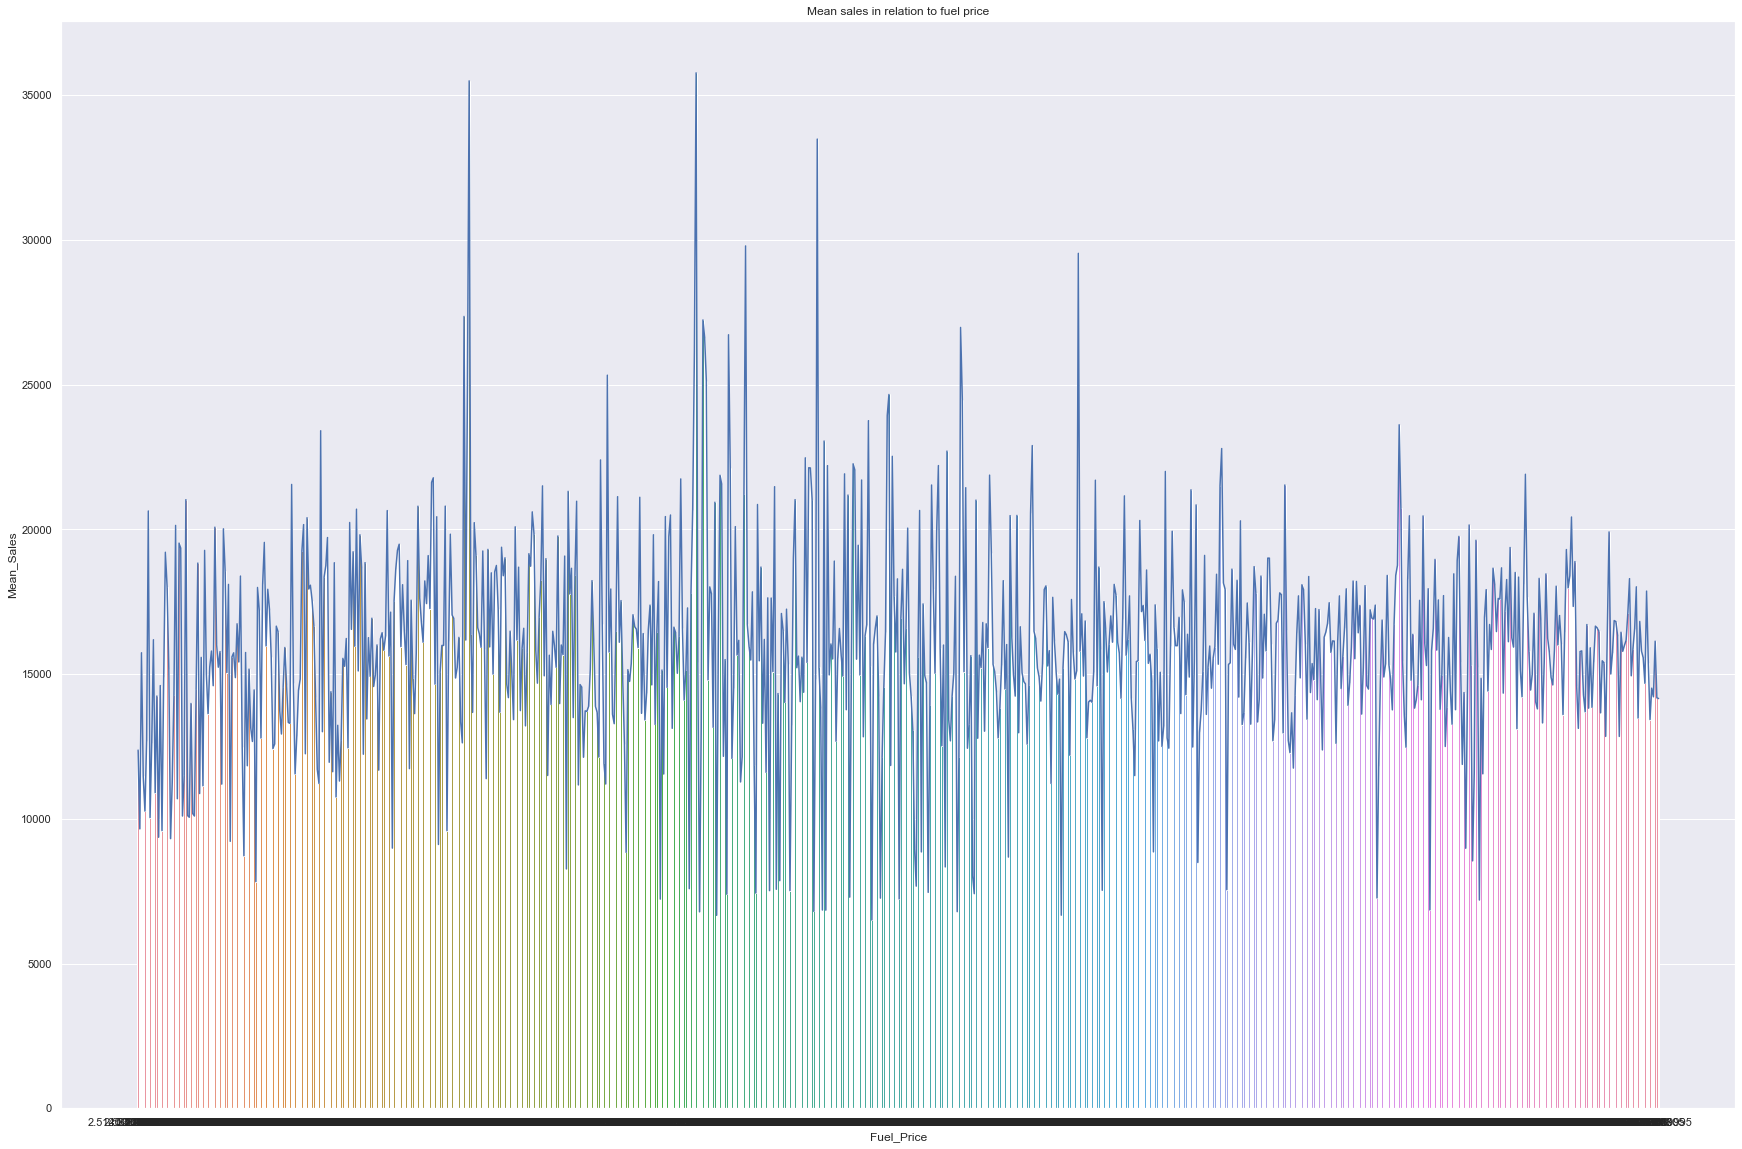

In [28]:
#mean weekly sales by type
sns.set(rc={'figure.figsize':(30, 20)})
fuel_df = pd.DataFrame(df_merged[['Fuel_Price','Weekly_Sales']].drop_duplicates().groupby('Fuel_Price').mean()).reset_index()
fuel_df.columns = ['Fuel_Price', 'Mean_Sales']
sns.barplot(x ='Fuel_Price', y='Mean_Sales', data=fuel_df);
plt.plot(fuel_df['Mean_Sales']);
plt.title('Mean sales in relation to fuel price')
del fuel_df

Fuel price appears to have a minimal effect on sales, mainly around the the mid-price range.

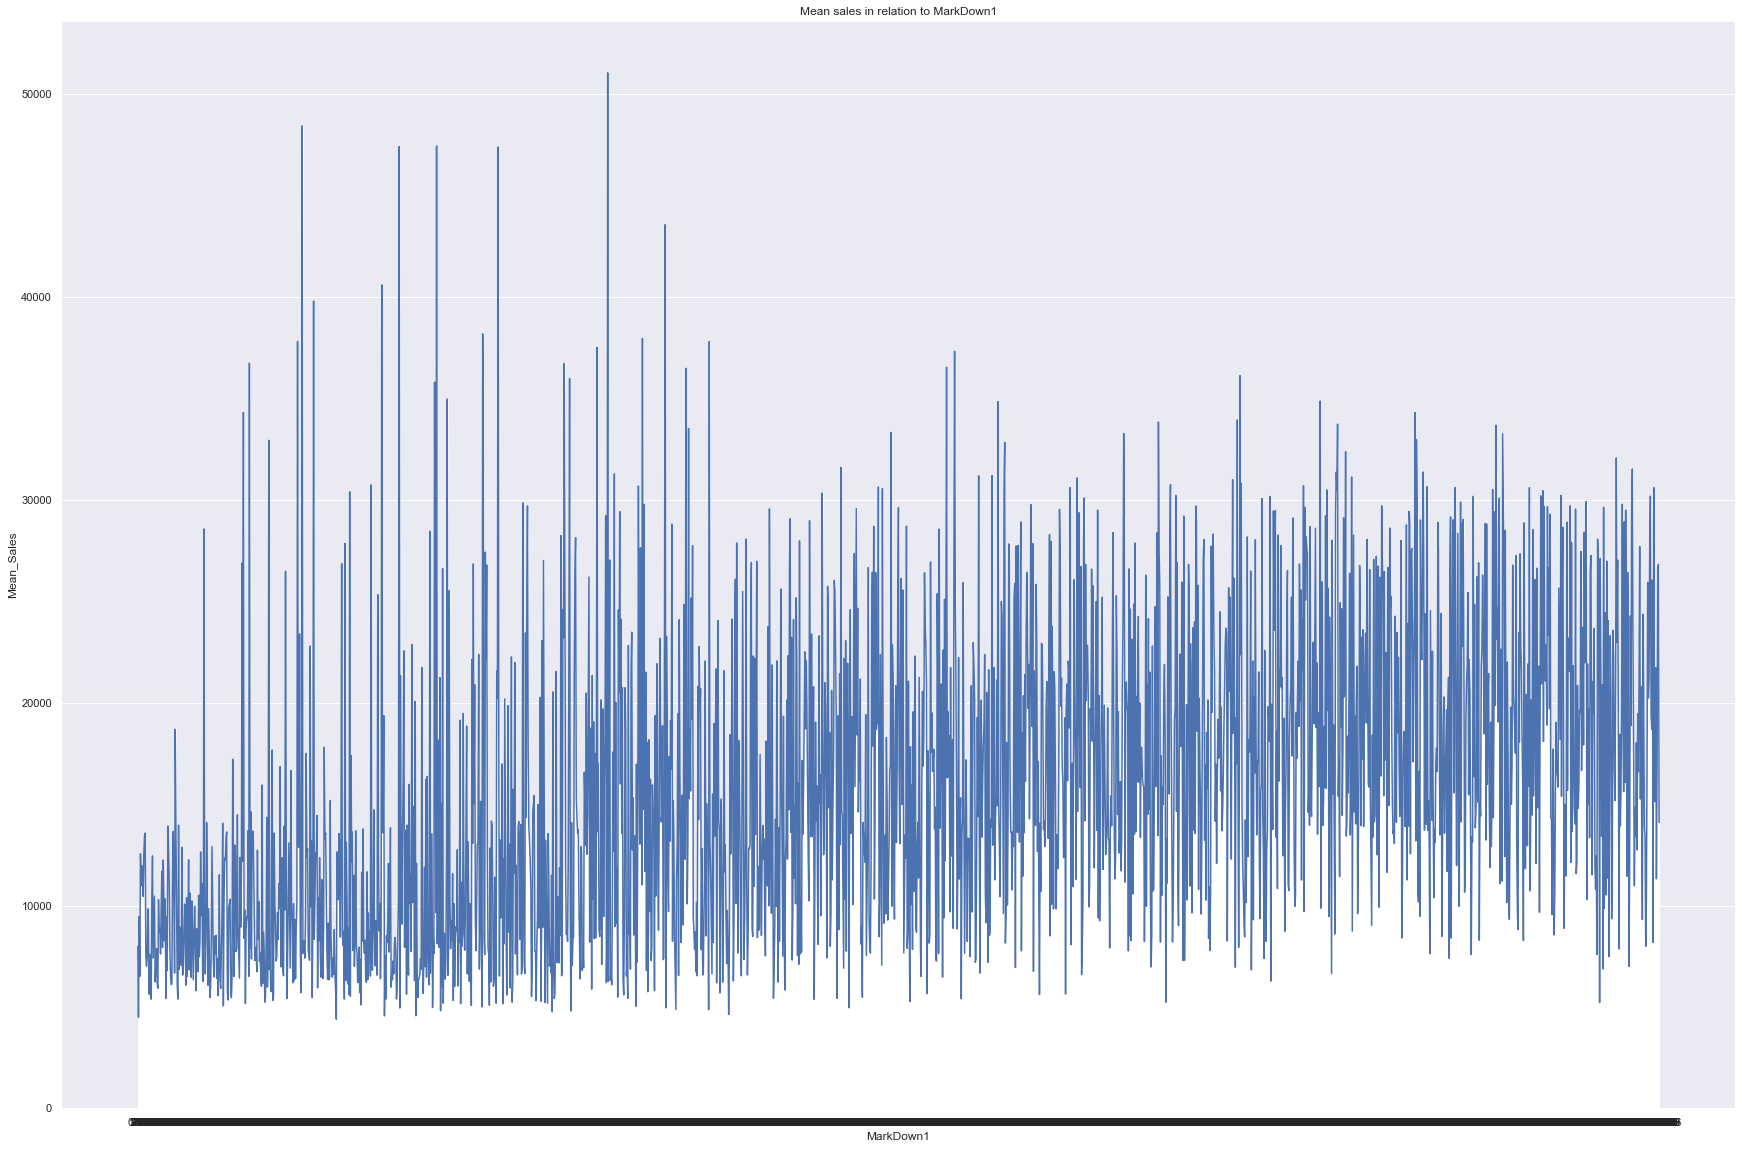

In [29]:
#mean weekly sales by type
sns.set(rc={'figure.figsize':(30, 20)})
MarkDown1_df = pd.DataFrame(df_merged[['MarkDown1','Weekly_Sales']].drop_duplicates().groupby('MarkDown1').mean()).reset_index()
MarkDown1_df.columns = ['MarkDown1', 'Mean_Sales']
sns.barplot(x ='MarkDown1', y='Mean_Sales', data=MarkDown1_df);
plt.plot(MarkDown1_df['Mean_Sales']);
plt.title('Mean sales in relation to MarkDown1')
del MarkDown1_df

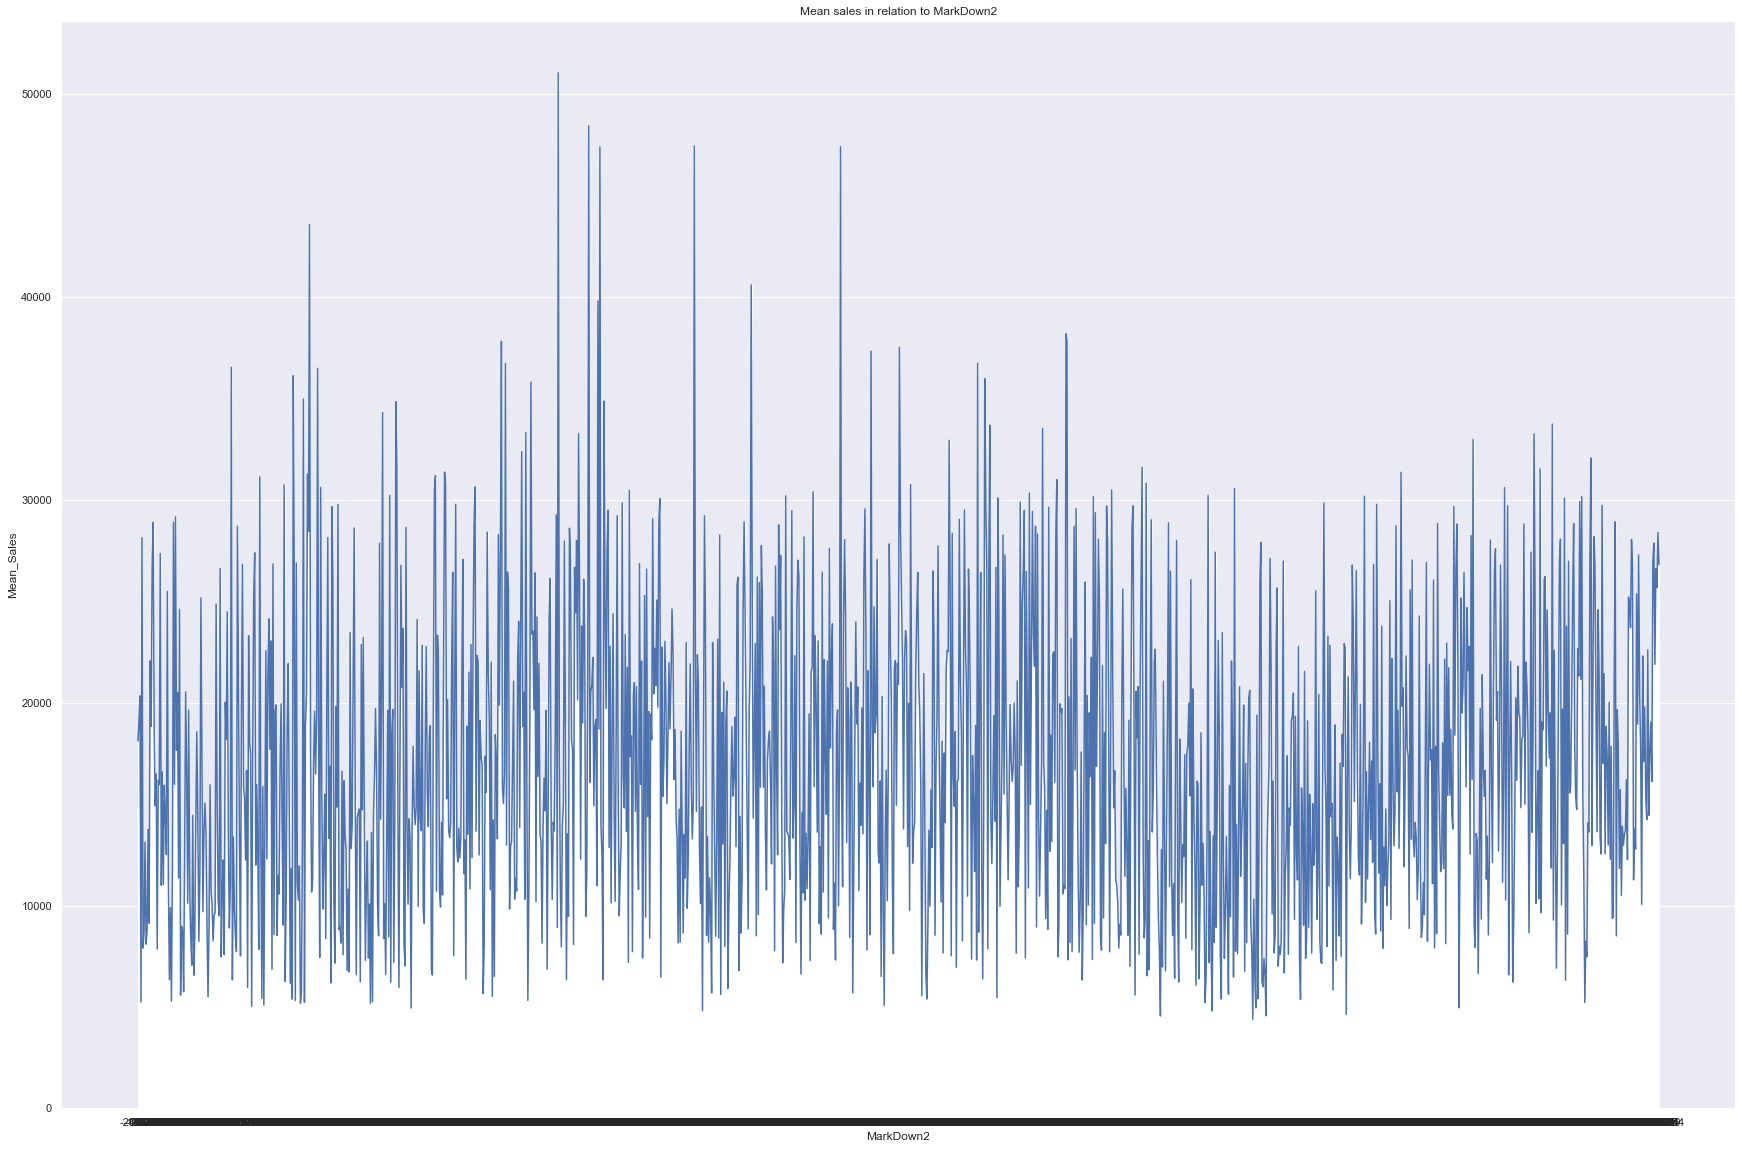

In [30]:
#mean weekly sales by type
sns.set(rc={'figure.figsize':(30, 20)})
MarkDown2_df = pd.DataFrame(df_merged[['MarkDown2','Weekly_Sales']].drop_duplicates().groupby('MarkDown2').mean()).reset_index()
MarkDown2_df.columns = ['MarkDown2', 'Mean_Sales']
sns.barplot(x ='MarkDown2', y='Mean_Sales', data=MarkDown2_df);
plt.plot(MarkDown2_df['Mean_Sales']);
plt.title('Mean sales in relation to MarkDown2')
del MarkDown2_df

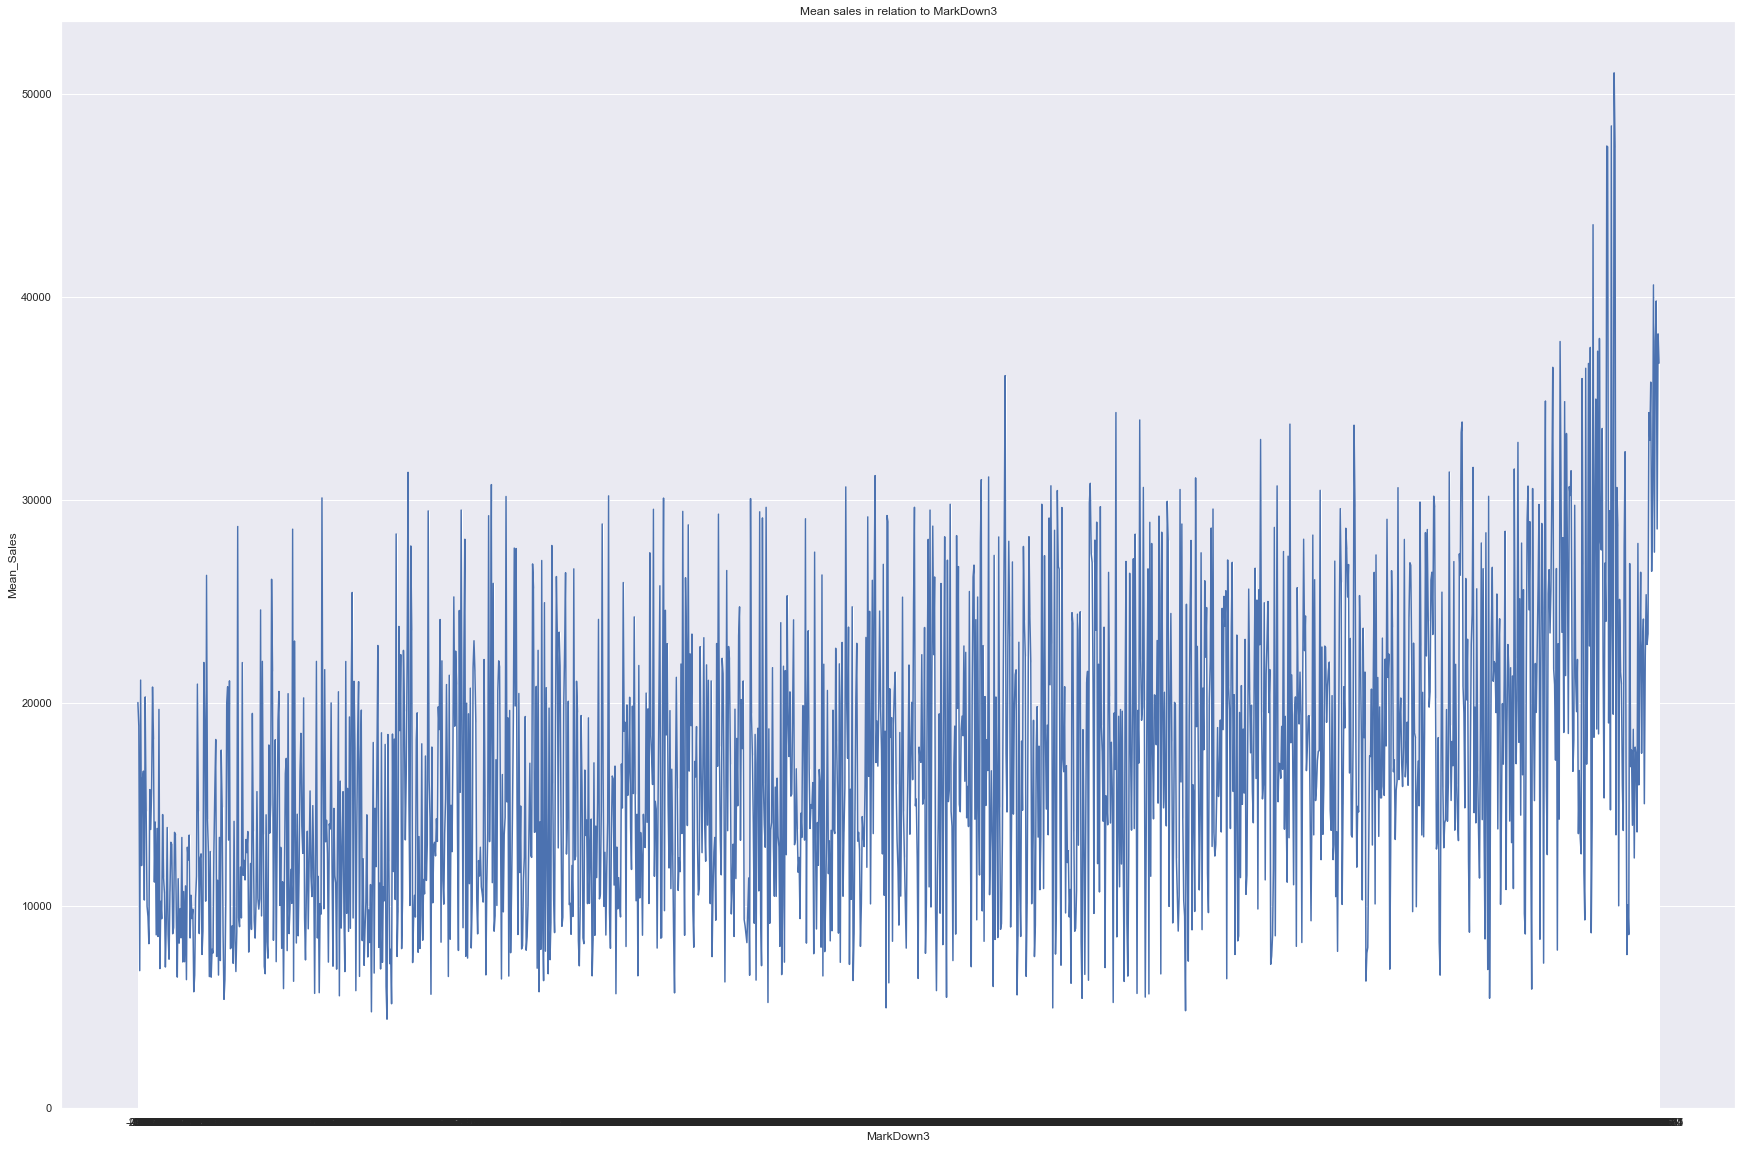

In [31]:
#mean weekly sales by type
sns.set(rc={'figure.figsize':(30, 20)})
MarkDown3_df = pd.DataFrame(df_merged[['MarkDown3','Weekly_Sales']].drop_duplicates().groupby('MarkDown3').mean()).reset_index()
MarkDown3_df.columns = ['MarkDown3', 'Mean_Sales']
sns.barplot(x ='MarkDown3', y='Mean_Sales', data=MarkDown3_df);
plt.plot(MarkDown3_df['Mean_Sales']);
plt.title('Mean sales in relation to MarkDown3')
del MarkDown3_df

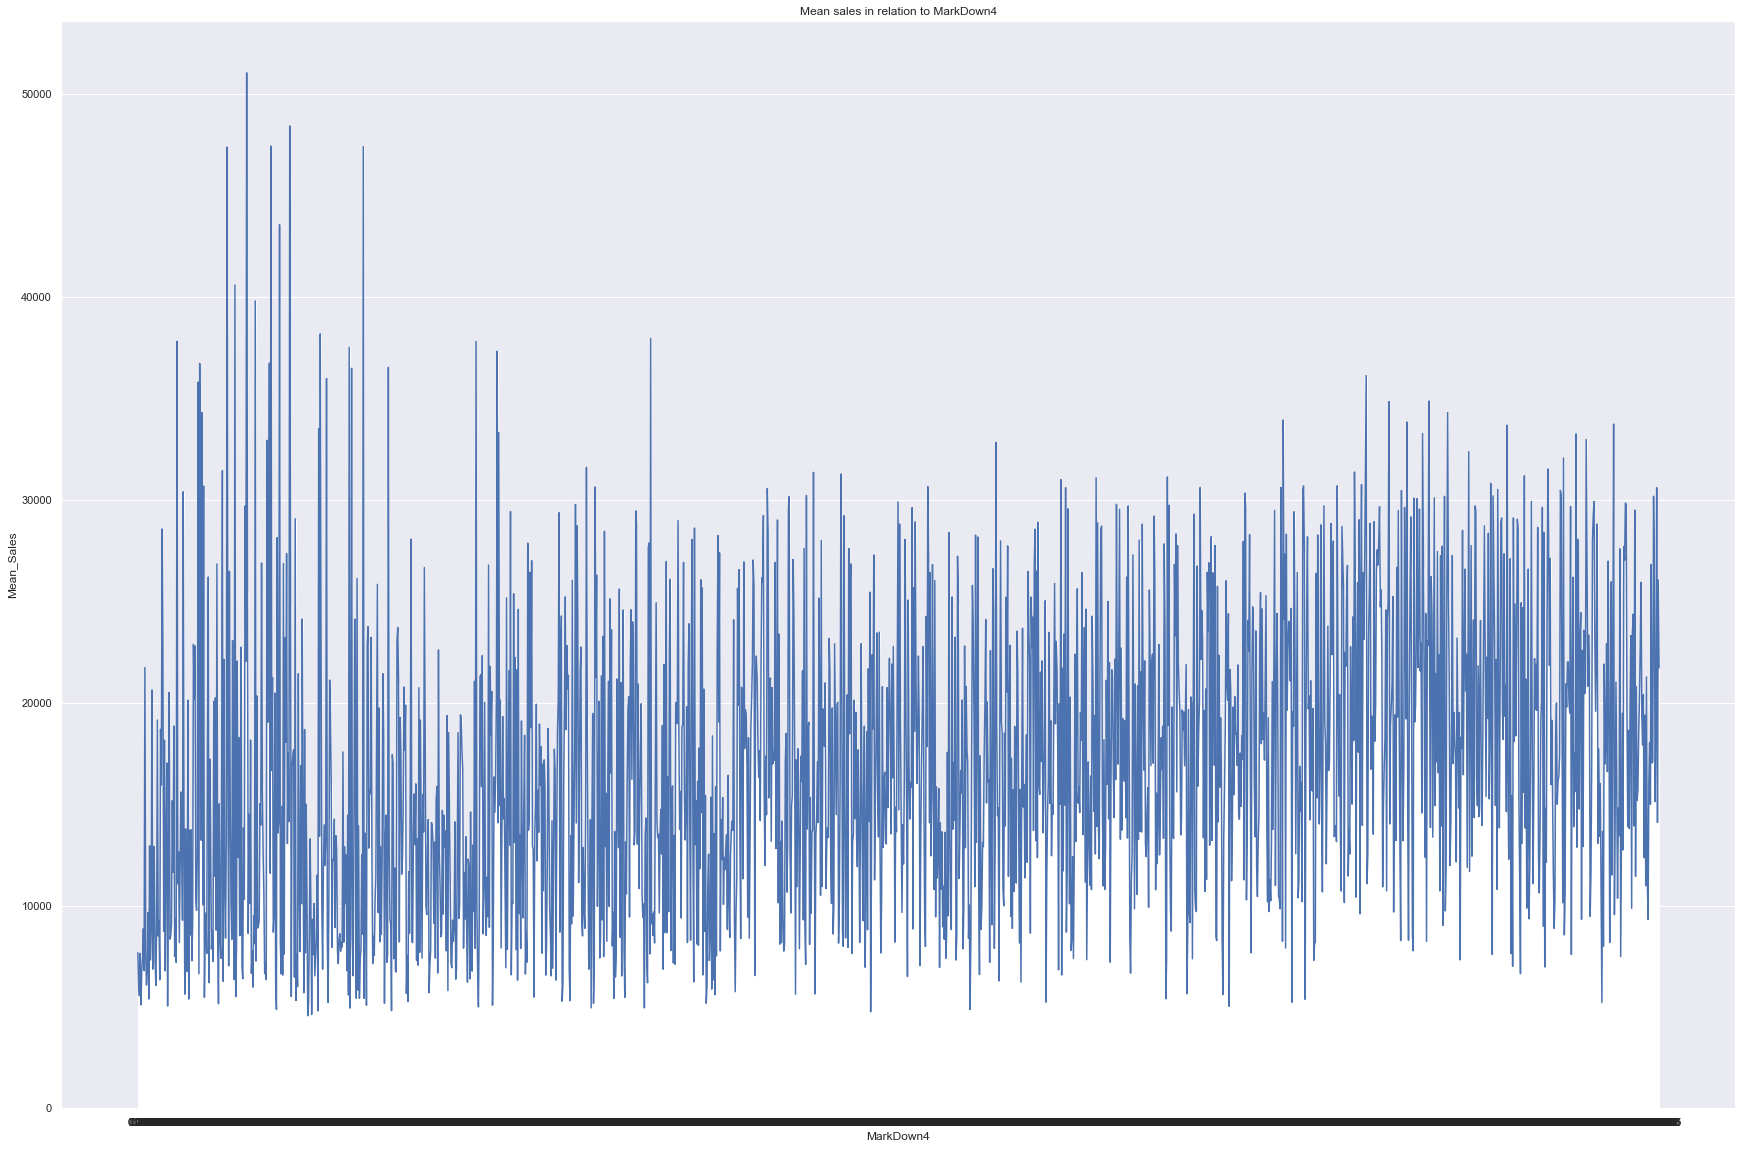

In [32]:
#mean weekly sales by type
sns.set(rc={'figure.figsize':(30, 20)})
MarkDown4_df = pd.DataFrame(df_merged[['MarkDown4','Weekly_Sales']].drop_duplicates().groupby('MarkDown4').mean()).reset_index()
MarkDown4_df.columns = ['MarkDown4', 'Mean_Sales']
sns.barplot(x ='MarkDown4', y='Mean_Sales', data=MarkDown4_df);
plt.plot(MarkDown4_df['Mean_Sales']);
plt.title('Mean sales in relation to MarkDown4')
del MarkDown4_df

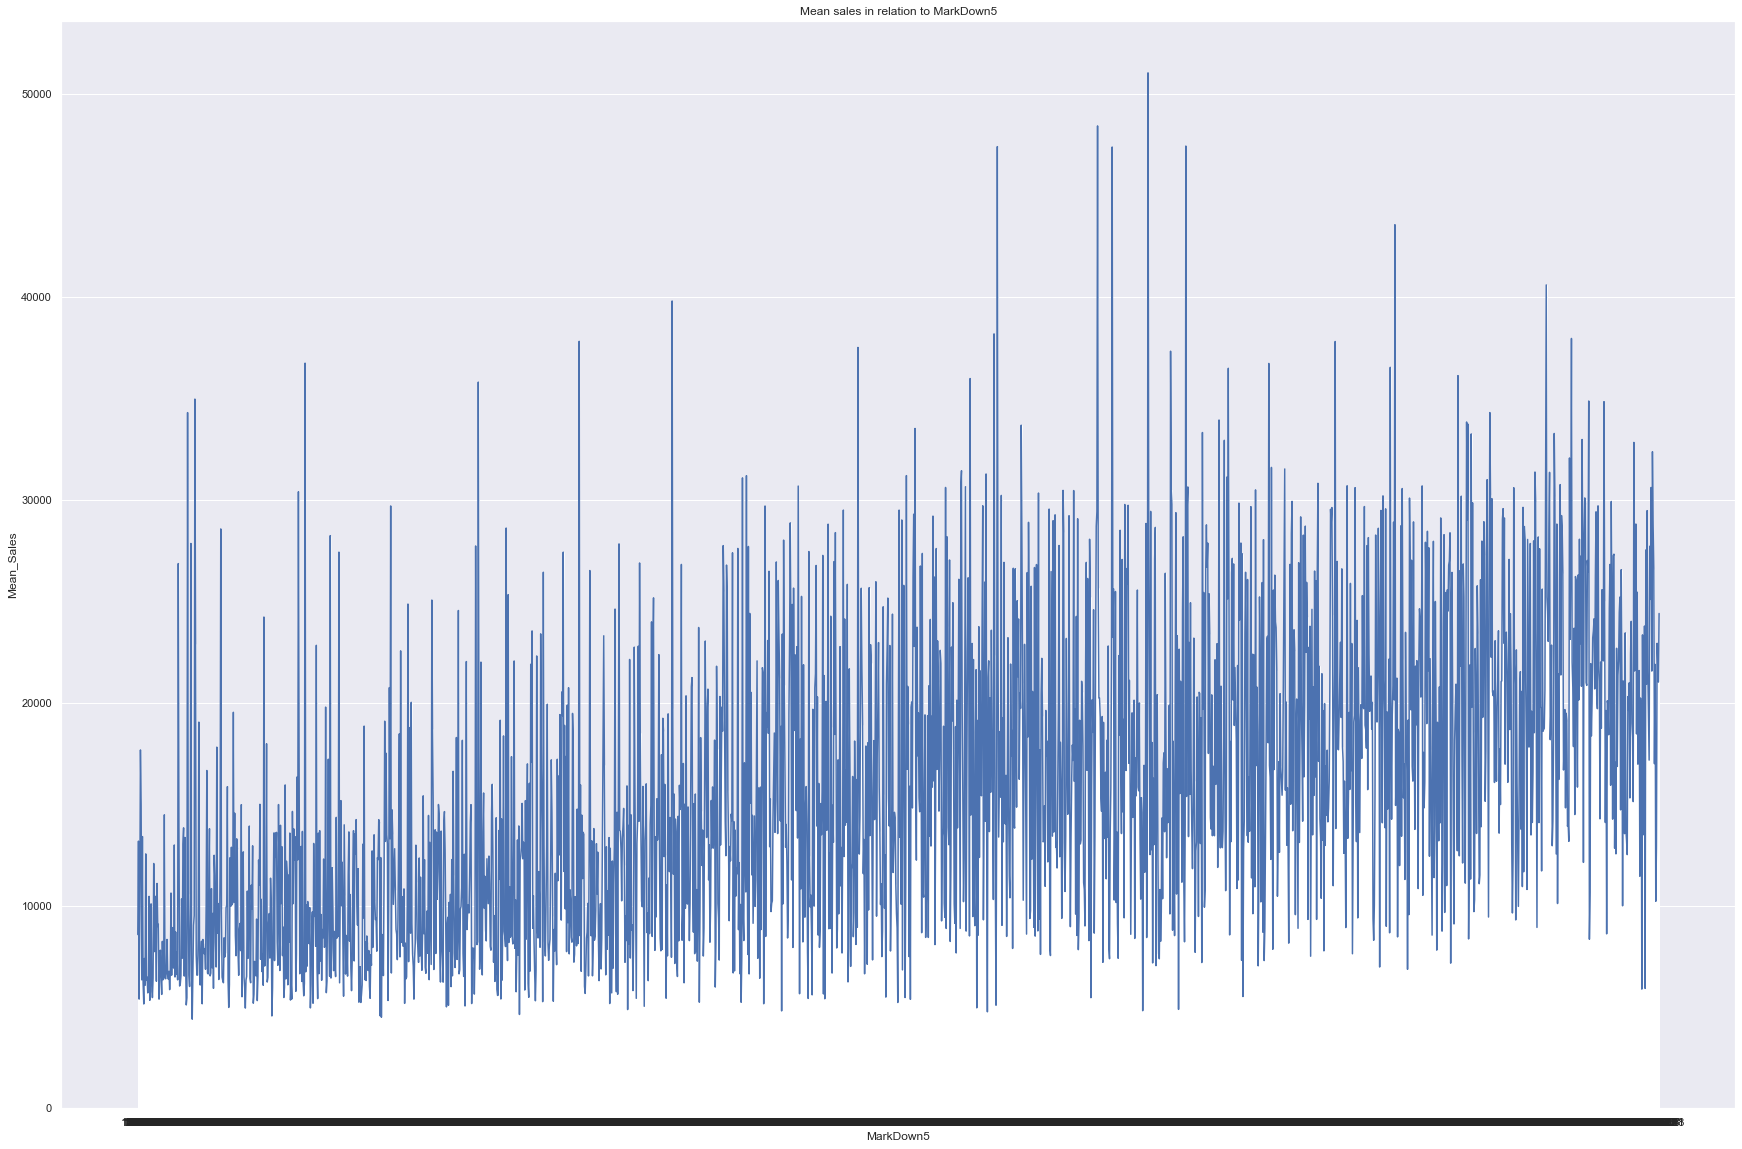

In [33]:
#mean weekly sales by type
sns.set(rc={'figure.figsize':(30, 20)})
MarkDown5_df = pd.DataFrame(df_merged[['MarkDown5','Weekly_Sales']].drop_duplicates().groupby('MarkDown5').mean()).reset_index()
MarkDown5_df.columns = ['MarkDown5', 'Mean_Sales']
sns.barplot(x ='MarkDown5', y='Mean_Sales', data=MarkDown5_df);
plt.plot(MarkDown5_df['Mean_Sales']);
plt.title('Mean sales in relation to MarkDown5')
del MarkDown5_df

In terms of all MarkDown features, there does appear to be variation in sales along with varying MarkDown.

## Drop unwanted features

In [34]:
df_merged = df_merged.drop(['Unemployment','IsHoliday'], axis=1)

## Feature engineering

### Create week number feature

In [35]:
df_merged['Week_num'] = df_merged['DateTime'].dt.week
df_merged['Year'] = df_merged['DateTime'].dt.year
df_merged.head()

Store  Dept        Date  Weekly_Sales  Temperature  Fuel_Price  MarkDown1  \
0      1     1  2010-02-05      24924.50        42.31       2.572        NaN   
1      1     2  2010-02-05      50605.27        42.31       2.572        NaN   
2      1     3  2010-02-05      13740.12        42.31       2.572        NaN   
3      1     4  2010-02-05      39954.04        42.31       2.572        NaN   
4      1     5  2010-02-05      32229.38        42.31       2.572        NaN   

   MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI Type    Size  \
0        NaN        NaN        NaN        NaN  211.096358    A  151315   
1        NaN        NaN        NaN        NaN  211.096358    A  151315   
2        NaN        NaN        NaN        NaN  211.096358    A  151315   
3        NaN        NaN        NaN        NaN  211.096358    A  151315   
4        NaN        NaN        NaN        NaN  211.096358    A  151315   

    DateTime  Week_num  Year  
0 2010-02-05         5  2010  
1 2010-02-05         5  2010  
2 2010-02-05         5  2010  
3 2010-02-05         5  2010  
4 2010-02-05         5  2010

In [36]:
df_merged.Week_num.nunique()

52

In [37]:
df_merged.Year.unique()

array([2010, 2011, 2012])

### Convert IsHoliday into Numerical Feature

In [38]:
#as shown in the plot above, spikes in sales at certain points in year around holidays
#convert holiday from boolean to numerical value so it can be quantified and utilised in the model
#df_merged['IsHolidayInt'] = [int(x) for x in list(df_merged.IsHoliday)]

In [39]:
#df_merged.head()

### Mean encode categorical features

In [40]:
mean_encoded_col = ['Store','Dept','Type','Week_num']

from tqdm import tqdm
from sklearn.model_selection import KFold

Target = 'Weekly_Sales'
global_mean = df_merged[Target].mean()
y_tr = df_merged[Target].values

for col in tqdm(mean_encoded_col):
    col_tr = df_merged[[col] + [Target]]
    corrcoefs = pd.DataFrame(columns = ['Cor'])

    # 3.1.1 Mean encodings - KFold scheme
    kf = KFold(n_splits = 5, shuffle = False, random_state = 0)
    col_tr[col + '_sales_week_mean_Kfold'] = global_mean
    
    for tr_ind, val_ind in kf.split(col_tr):
        X_tr, X_val = col_tr.iloc[tr_ind], col_tr.iloc[val_ind]
        means = X_val[col].map(X_tr.groupby(col)[Target].mean())
        X_val[col + '_sales_week_mean_Kfold'] = means
        col_tr.iloc[val_ind] = X_val

    col_tr.fillna(global_mean, inplace = True)
    corrcoefs.loc[col + '_sales_week_mean_Kfold'] = np.corrcoef(y_tr, col_tr[col + '_sales_week_mean_Kfold'])[0][1]


     # 3.1.2 Mean encodings - Leave-one-out scheme
    item_id_target_sum = col_tr.groupby(col)[Target].sum()
    item_id_target_count = col_tr.groupby(col)[Target].count()
    col_tr[col + '_sales_week_sum'] = col_tr[col].map(item_id_target_sum)
    col_tr[col + '_sales_week_count'] = col_tr[col].map(item_id_target_count)
    col_tr[col + '_target_mean_LOO'] = (col_tr[col + '_sales_week_sum'] - col_tr[Target]) / (col_tr[col + '_sales_week_count'] - 1)
    col_tr.fillna(global_mean, inplace = True)
    corrcoefs.loc[col + '_target_mean_LOO'] = np.corrcoef(y_tr, col_tr[col + '_target_mean_LOO'])[0][1]


     # 3.1.3 Mean encodings - Smoothing
    item_id_target_mean = col_tr.groupby(col)[Target].mean()
    item_id_target_count = col_tr.groupby(col)[Target].count()
    col_tr[col + '_sales_week_mean'] = col_tr[col].map(item_id_target_mean)
    col_tr[col + '_sales_week_count'] = col_tr[col].map(item_id_target_count)
    alpha = 100
    col_tr[col + '_sales_week_mean_Smooth'] = (col_tr[col + '_sales_week_mean'] *  col_tr[col + '_sales_week_count'] + global_mean * alpha) / (alpha + col_tr[col + '_sales_week_count'])
    col_tr[col + '_sales_week_mean_Smooth'].fillna(global_mean, inplace=True)
    corrcoefs.loc[col + '_sales_week_mean_Smooth'] = np.corrcoef(y_tr, col_tr[col + '_sales_week_mean_Smooth'])[0][1]


    # 3.1.4 Mean encodings - Expanding mean scheme
    cumsum = col_tr.groupby(col)[Target].cumsum() - col_tr[Target]
    sumcnt = col_tr.groupby(col).cumcount()
    col_tr[col + '_sales_week_mean_Expanding'] = cumsum / sumcnt
    col_tr[col + '_sales_week_mean_Expanding'].fillna(global_mean, inplace=True)
    corrcoefs.loc[col + '_sales_week_mean_Expanding'] = np.corrcoef(y_tr, col_tr[col + '_sales_week_mean_Expanding'])[0][1]

    df_merged = pd.concat([df_merged, col_tr[corrcoefs['Cor'].idxmax()]], axis = 1)
    print(corrcoefs.sort_values('Cor'))

    

 25%|██▌       | 1/4 [00:00<00:00,  3.08it/s]

                                      Cor
Store_sales_week_mean_Kfold      0.048446
Store_sales_week_mean_Expanding  0.304708
Store_target_mean_LOO            0.305705
Store_sales_week_mean_Smooth     0.306006


 50%|█████     | 2/4 [00:00<00:00,  3.18it/s]

                                     Cor
Dept_sales_week_mean_Kfold      0.716156
Dept_sales_week_mean_Smooth     0.734195
Dept_target_mean_LOO            0.734228
Dept_sales_week_mean_Expanding  0.747110


 75%|███████▌  | 3/4 [00:01<00:00,  2.70it/s]

                                     Cor
Type_sales_week_mean_Kfold      0.162263
Type_target_mean_LOO            0.189030
Type_sales_week_mean_Smooth     0.189060
Type_sales_week_mean_Expanding  0.205713


100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

                                         Cor
Week_num_sales_week_mean_Kfold      0.049599
Week_num_target_mean_LOO            0.075060
Week_num_sales_week_mean_Smooth     0.076696
Week_num_sales_week_mean_Expanding  0.100752


In [41]:
df_merged.head()

Store  Dept        Date  Weekly_Sales  Temperature  Fuel_Price  MarkDown1  \
0      1     1  2010-02-05      24924.50        42.31       2.572        NaN   
1      1     2  2010-02-05      50605.27        42.31       2.572        NaN   
2      1     3  2010-02-05      13740.12        42.31       2.572        NaN   
3      1     4  2010-02-05      39954.04        42.31       2.572        NaN   
4      1     5  2010-02-05      32229.38        42.31       2.572        NaN   

   MarkDown2  MarkDown3  MarkDown4  ...         CPI  Type    Size   DateTime  \
0        NaN        NaN        NaN  ...  211.096358     A  151315 2010-02-05   
1        NaN        NaN        NaN  ...  211.096358     A  151315 2010-02-05   
2        NaN        NaN        NaN  ...  211.096358     A  151315 2010-02-05   
3        NaN        NaN        NaN  ...  211.096358     A  151315 2010-02-05   
4        NaN        NaN        NaN  ...  211.096358     A  151315 2010-02-05   

  Week_num  Year  Store_sales_week_mean_Smooth  \
0        5  2010                  21655.514828   
1        5  2010                  21655.514828   
2        5  2010                  21655.514828   
3        5  2010                  21655.514828   
4        5  2010                  21655.514828   

   Dept_sales_week_mean_Expanding  Type_sales_week_mean_Expanding  \
0                     15978.78611                     15978.78611   
1                     15978.78611                     24924.50000   
2                     15978.78611                     37764.88500   
3                     15978.78611                     29756.63000   
4                     15978.78611                     32305.98250   

   Week_num_sales_week_mean_Expanding  
0                         15978.78611  
1                         24924.50000  
2                         37764.88500  
3                         29756.63000  
4                         32305.98250  

[5 rows x 21 columns]

In [42]:
df_merged.Week_num.unique()

array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,  1,  2,  3,
        4])

In [43]:
df_merged.to_pickle('data.pickle.gzde', compression='gzip')

### Create 12-month weekly sales lagged feature (based on week number)

As on the Kaggle test dataset, predictions are for weekly sales up to 7 months in advance. In addition, given the similar annual sales patterns shown in the plots above, lags will be for 12 months previous.

In [44]:
df = pd.read_pickle('data.pickle.gzde', compression='gzip')

In [45]:
#function to create time lags
def lag_feature(df, lags, col):
    tmp = df[['Year','Week_num','Store','Dept',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['Year','Week_num','Store','Dept', col+'_lag_'+str(i)]
        shifted['Year'] += i
        df = pd.merge(df, shifted, on=['Year','Week_num','Store','Dept'], how='left')
    return df

In [46]:
cols = ['Weekly_Sales', 'Store_sales_week_mean_Smooth',
        'Dept_sales_week_mean_Expanding', 'Type_sales_week_mean_Expanding',
        'Week_num_sales_week_mean_Expanding']

for col in cols:
    df = lag_feature(df, [1], col)

df.head()

Store  Dept        Date  Weekly_Sales  Temperature  Fuel_Price  MarkDown1  \
0      1     1  2010-02-05      24924.50        42.31       2.572        NaN   
1      1     2  2010-02-05      50605.27        42.31       2.572        NaN   
2      1     3  2010-02-05      13740.12        42.31       2.572        NaN   
3      1     4  2010-02-05      39954.04        42.31       2.572        NaN   
4      1     5  2010-02-05      32229.38        42.31       2.572        NaN   

   MarkDown2  MarkDown3  MarkDown4  ...  Year  Store_sales_week_mean_Smooth  \
0        NaN        NaN        NaN  ...  2010                  21655.514828   
1        NaN        NaN        NaN  ...  2010                  21655.514828   
2        NaN        NaN        NaN  ...  2010                  21655.514828   
3        NaN        NaN        NaN  ...  2010                  21655.514828   
4        NaN        NaN        NaN  ...  2010                  21655.514828   

  Dept_sales_week_mean_Expanding  Type_sales_week_mean_Expanding  \
0                    15978.78611                     15978.78611   
1                    15978.78611                     24924.50000   
2                    15978.78611                     37764.88500   
3                    15978.78611                     29756.63000   
4                    15978.78611                     32305.98250   

  Week_num_sales_week_mean_Expanding  Weekly_Sales_lag_1  \
0                        15978.78611                 NaN   
1                        24924.50000                 NaN   
2                        37764.88500                 NaN   
3                        29756.63000                 NaN   
4                        32305.98250                 NaN   

   Store_sales_week_mean_Smooth_lag_1  Dept_sales_week_mean_Expanding_lag_1  \
0                                 NaN                                   NaN   
1                                 NaN                                   NaN   
2                                 NaN                                   NaN   
3                                 NaN                                   NaN   
4                                 NaN                                   NaN   

   Type_sales_week_mean_Expanding_lag_1  \
0                                   NaN   
1                                   NaN   
2                                   NaN   
3                                   NaN   
4                                   NaN   

   Week_num_sales_week_mean_Expanding_lag_1  
0                                       NaN  
1                                       NaN  
2                                       NaN  
3                                       NaN  
4                                       NaN  

[5 rows x 26 columns]

In [47]:
features_to_drop = ['Store_sales_week_mean_Smooth','Dept_sales_week_mean_Expanding',
                    'Type_sales_week_mean_Expanding',
                    'Week_num_sales_week_mean_Expanding','Type']

df = df.drop(features_to_drop, axis=1)

### Drop the first 12 months (due to NaNs created through lag values)

In [48]:
mask1 = df['Year'] > 2010

In [49]:
df = df[mask1]

In [50]:
# delete all rows with column 'Year' has value 2011 and 'Week_num' <5
index = df[ (df['Year'] == 2011) & (df['Week_num'] < 5) ].index
df.drop(index, inplace=True)

In [51]:
df.head()

Store  Dept        Date  Weekly_Sales  Temperature  Fuel_Price  \
3729      1     1  2011-02-04      21665.76        42.27       2.989   
3730      1     2  2011-02-04      46829.12        42.27       2.989   
3731      1     3  2011-02-04      11012.52        42.27       2.989   
3732      1     4  2011-02-04      35870.49        42.27       2.989   
3733      1     5  2011-02-04      31280.62        42.27       2.989   

      MarkDown1  MarkDown2  MarkDown3  MarkDown4  ...         CPI    Size  \
3729        NaN        NaN        NaN        NaN  ...  212.566881  151315   
3730        NaN        NaN        NaN        NaN  ...  212.566881  151315   
3731        NaN        NaN        NaN        NaN  ...  212.566881  151315   
3732        NaN        NaN        NaN        NaN  ...  212.566881  151315   
3733        NaN        NaN        NaN        NaN  ...  212.566881  151315   

       DateTime Week_num  Year  Weekly_Sales_lag_1  \
3729 2011-02-04        5  2011            24924.50   
3730 2011-02-04        5  2011            50605.27   
3731 2011-02-04        5  2011            13740.12   
3732 2011-02-04        5  2011            39954.04   
3733 2011-02-04        5  2011            32229.38   

      Store_sales_week_mean_Smooth_lag_1  \
3729                        21655.514828   
3730                        21655.514828   
3731                        21655.514828   
3732                        21655.514828   
3733                        21655.514828   

      Dept_sales_week_mean_Expanding_lag_1  \
3729                           15978.78611   
3730                           15978.78611   
3731                           15978.78611   
3732                           15978.78611   
3733                           15978.78611   

      Type_sales_week_mean_Expanding_lag_1  \
3729                           15978.78611   
3730                           24924.50000   
3731                           37764.88500   
3732                           29756.63000   
3733                           32305.98250   

      Week_num_sales_week_mean_Expanding_lag_1  
3729                               15978.78611  
3730                               24924.50000  
3731                               37764.88500  
3732                               29756.63000  
3733                               32305.98250  

[5 rows x 21 columns]

In [52]:
#replace nans with 0
df = df.replace(np.nan, 0)

### One-Hot Encode Store and Dept features

In [53]:
#as shown by the above plots, single stores weekly sales differ from each other
#store categorical data will be converted to dummy variables so stores can be quantified,
#compared and utilised by the model to predict weekly sales

dept_num_dummies = pd.get_dummies(df.Dept, prefix='Dept')
df = pd.concat([dept_num_dummies, df], axis=1)

In [54]:
store_num_dummies = pd.get_dummies(df.Store, prefix='Store')
df = pd.concat([store_num_dummies, df], axis=1)

In [55]:
df.head()

Store_1  Store_2  Store_3  Store_4  Store_5  Store_6  Store_7  Store_8  \
3729        1        0        0        0        0        0        0        0   
3730        1        0        0        0        0        0        0        0   
3731        1        0        0        0        0        0        0        0   
3732        1        0        0        0        0        0        0        0   
3733        1        0        0        0        0        0        0        0   

      Store_9  Store_10  ...         CPI    Size   DateTime  Week_num  Year  \
3729        0         0  ...  212.566881  151315 2011-02-04         5  2011   
3730        0         0  ...  212.566881  151315 2011-02-04         5  2011   
3731        0         0  ...  212.566881  151315 2011-02-04         5  2011   
3732        0         0  ...  212.566881  151315 2011-02-04         5  2011   
3733        0         0  ...  212.566881  151315 2011-02-04         5  2011   

      Weekly_Sales_lag_1  Store_sales_week_mean_Smooth_lag_1  \
3729            24924.50                        21655.514828   
3730            50605.27                        21655.514828   
3731            13740.12                        21655.514828   
3732            39954.04                        21655.514828   
3733            32229.38                        21655.514828   

      Dept_sales_week_mean_Expanding_lag_1  \
3729                           15978.78611   
3730                           15978.78611   
3731                           15978.78611   
3732                           15978.78611   
3733                           15978.78611   

      Type_sales_week_mean_Expanding_lag_1  \
3729                           15978.78611   
3730                           24924.50000   
3731                           37764.88500   
3732                           29756.63000   
3733                           32305.98250   

      Week_num_sales_week_mean_Expanding_lag_1  
3729                               15978.78611  
3730                               24924.50000  
3731                               37764.88500  
3732                               29756.63000  
3733                               32305.98250  

[5 rows x 147 columns]

### Encode week number (cyclical)

In [56]:
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [57]:
df = encode(df, 'Week_num', 52)

In [58]:
df.head()

Store_1  Store_2  Store_3  Store_4  Store_5  Store_6  Store_7  Store_8  \
3729        1        0        0        0        0        0        0        0   
3730        1        0        0        0        0        0        0        0   
3731        1        0        0        0        0        0        0        0   
3732        1        0        0        0        0        0        0        0   
3733        1        0        0        0        0        0        0        0   

      Store_9  Store_10  ...   DateTime  Week_num  Year  Weekly_Sales_lag_1  \
3729        0         0  ... 2011-02-04         5  2011            24924.50   
3730        0         0  ... 2011-02-04         5  2011            50605.27   
3731        0         0  ... 2011-02-04         5  2011            13740.12   
3732        0         0  ... 2011-02-04         5  2011            39954.04   
3733        0         0  ... 2011-02-04         5  2011            32229.38   

      Store_sales_week_mean_Smooth_lag_1  \
3729                        21655.514828   
3730                        21655.514828   
3731                        21655.514828   
3732                        21655.514828   
3733                        21655.514828   

      Dept_sales_week_mean_Expanding_lag_1  \
3729                           15978.78611   
3730                           15978.78611   
3731                           15978.78611   
3732                           15978.78611   
3733                           15978.78611   

      Type_sales_week_mean_Expanding_lag_1  \
3729                           15978.78611   
3730                           24924.50000   
3731                           37764.88500   
3732                           29756.63000   
3733                           32305.98250   

      Week_num_sales_week_mean_Expanding_lag_1  Week_num_sin  Week_num_cos  
3729                               15978.78611      0.568065      0.822984  
3730                               24924.50000      0.568065      0.822984  
3731                               37764.88500      0.568065      0.822984  
3732                               29756.63000      0.568065      0.822984  
3733                               32305.98250      0.568065      0.822984  

[5 rows x 149 columns]

In [59]:
df = df.drop(['Store','Dept','Year','DateTime','Week_num','Date'], axis=1)

In [60]:
df.to_pickle('data2.pickle.gzde', compression='gzip')

## Splitting the data into train and test

In [61]:
df2 = pd.read_pickle('data2.pickle.gzde', compression='gzip')

In [62]:
train_set, test_set = train_test_split(df2, test_size=0.3,random_state=42)

In [63]:
train_set.shape, test_set.shape

((188437, 143), (80759, 143))

# Building the models

## Linear Regression

In [64]:
train_linear = train_set.copy()
test_linear = test_set.copy()

In [65]:
X_train = train_linear.drop(['Weekly_Sales'], axis=1)
X_train = np.matrix((X_train).values)
y_train = np.matrix((train_linear['Weekly_Sales']).values)

In [66]:
y_train = y_train.T
X_train.shape, y_train.shape

((188437, 142), (188437, 1))

In [67]:
def featureNormalize(X):
    X_norm = X
    mu = np.zeros((1, X.shape[1]))
    sigma = np.zeros((1, X.shape[1]))
    for i in range(X.shape[1]):
        mu[:,i] = np.mean(X[:,i])
        sigma[:,i] = np.std(X[:,i], dtype=np.float64)
        X_norm[:,i] = (X[:,i] - float(mu[:,i]))/float(sigma[:,i])
    return X_norm, mu, sigma

In [68]:
print('Normalising features...')

X_norm, mu, sigma = featureNormalize(X_train)

Normalising features...


In [69]:
#add intercept term to X
m = len(y_train)
X_padded = np.column_stack((np.ones((m,1)),X_norm)) #add column of ones to x
theta = np.zeros((X_padded.shape[1],1))

In [70]:
# Initialize learning rate α.
alpha = 0.15

# Check the dimensions of the matrices.
X_padded.shape, y_train.shape, theta.shape

((188437, 143), (188437, 1), (143, 1))

In [71]:
# Create a function to compute cost.
def computeCost(x, y, theta):
    """
    Compute the cost function.
    Args:
        x: a m by n+1 matrix
        y: a m by 1 vector
        theta: a n+1 by 1 vector
    Returns:
        cost: float
    """
    m = len(x)
    cost = np.sum(np.square((x * theta) - y)) / (2 * m)
    return cost

In [72]:
# Create a function to implement gradient descent.
def gradientDescent(x,y, theta, iterations):
    """
    Implement gradient descent.
    Args:
        x: a m by n+1 matrix
        theta: a n+1 by 1 vector
    Return:
        theta: a n+1 by 1 vector
        J_vals: a #iterations by 1 vector
    """
    m = len(x)
    J_vals = []
    
    for i in range(iterations):
        error = (x * theta) - y
        for j in range(len(theta.flat)):
            theta.T[0, j] = theta.T[0, j] - (alpha/m) * np.sum(np.multiply(error, x[:, j]))
        J_vals.append(computeCost(x, y, theta))
    return (theta, J_vals)

In [73]:
theta, J_vals = gradientDescent(X_padded, y_train, theta, iterations=50)

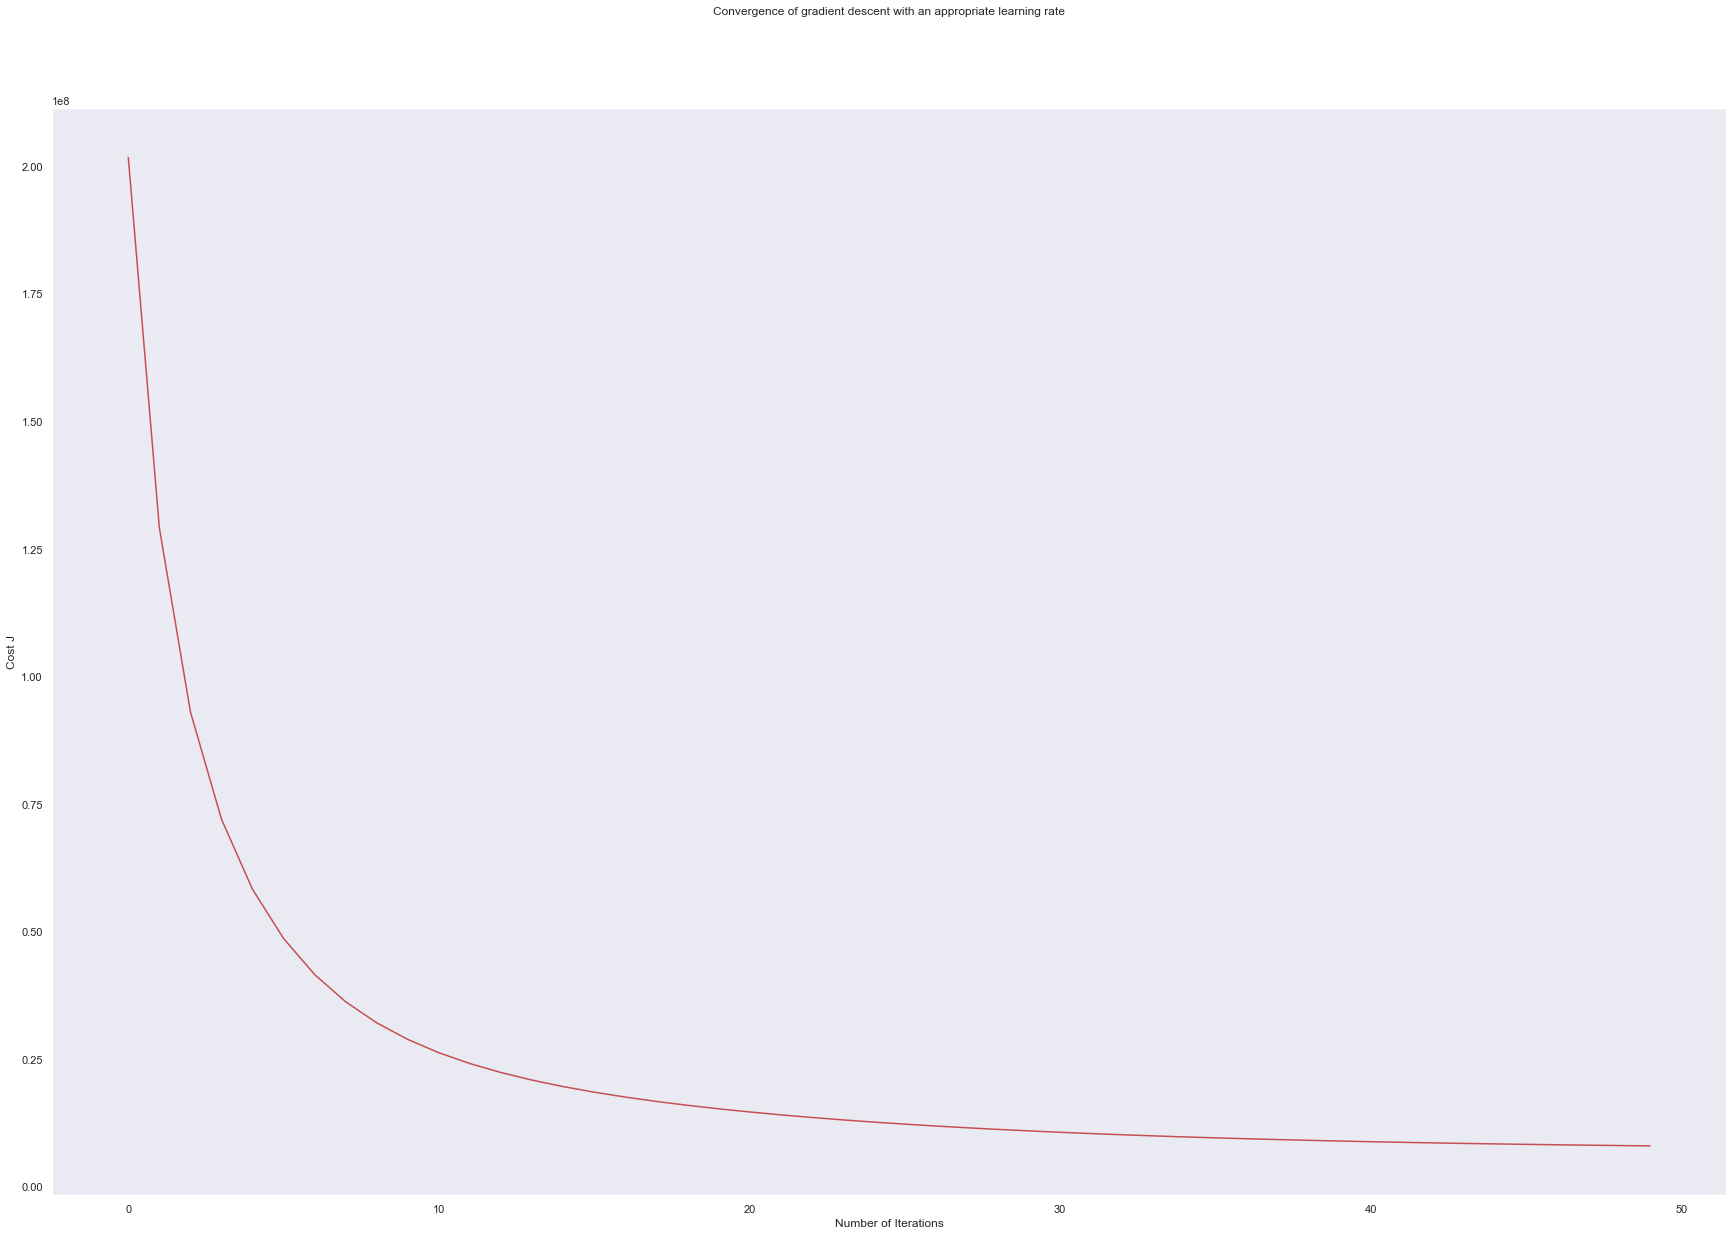

In [74]:
plt.xlabel('Number of Iterations')
plt.ylabel('Cost J')
plt.title('Convergence of gradient descent with an appropriate learning rate', y=1.08)
plt.grid()
plt.plot(range(50), J_vals, 'r')

### Testing the model

In [75]:
X_test = test_linear.drop(['Weekly_Sales'], axis=1)
X_test = np.matrix((X_test).values)
y_test = np.matrix((test_linear['Weekly_Sales']).values)
y_test = y_test.T

In [76]:
X_test.shape, y_test.shape

((80759, 142), (80759, 1))

In [77]:
def featureNormalizeTest(X, mu, sigma):
    X_norm_test = X
    for i in range(X.shape[1]):
        X_norm_test[:,i] = (X[:,i] - float(mu[:,i]))/float(sigma[:,i])
    return X_norm_test

In [78]:
print('Normalising features...')

X_norm_test = featureNormalizeTest(X_test, mu, sigma)

Normalising features...


In [79]:
#add intercept term to X
m = len(y_test)

X_padded_test = np.column_stack((np.ones((m,1)),X_norm_test)) #add column of ones to x

In [80]:
X_padded_test.shape, y_test.shape, theta.shape

((80759, 143), (80759, 1), (143, 1))

In [81]:
y_predict = X_padded_test * theta

### Evaluating the model

In [82]:
from sklearn import metrics

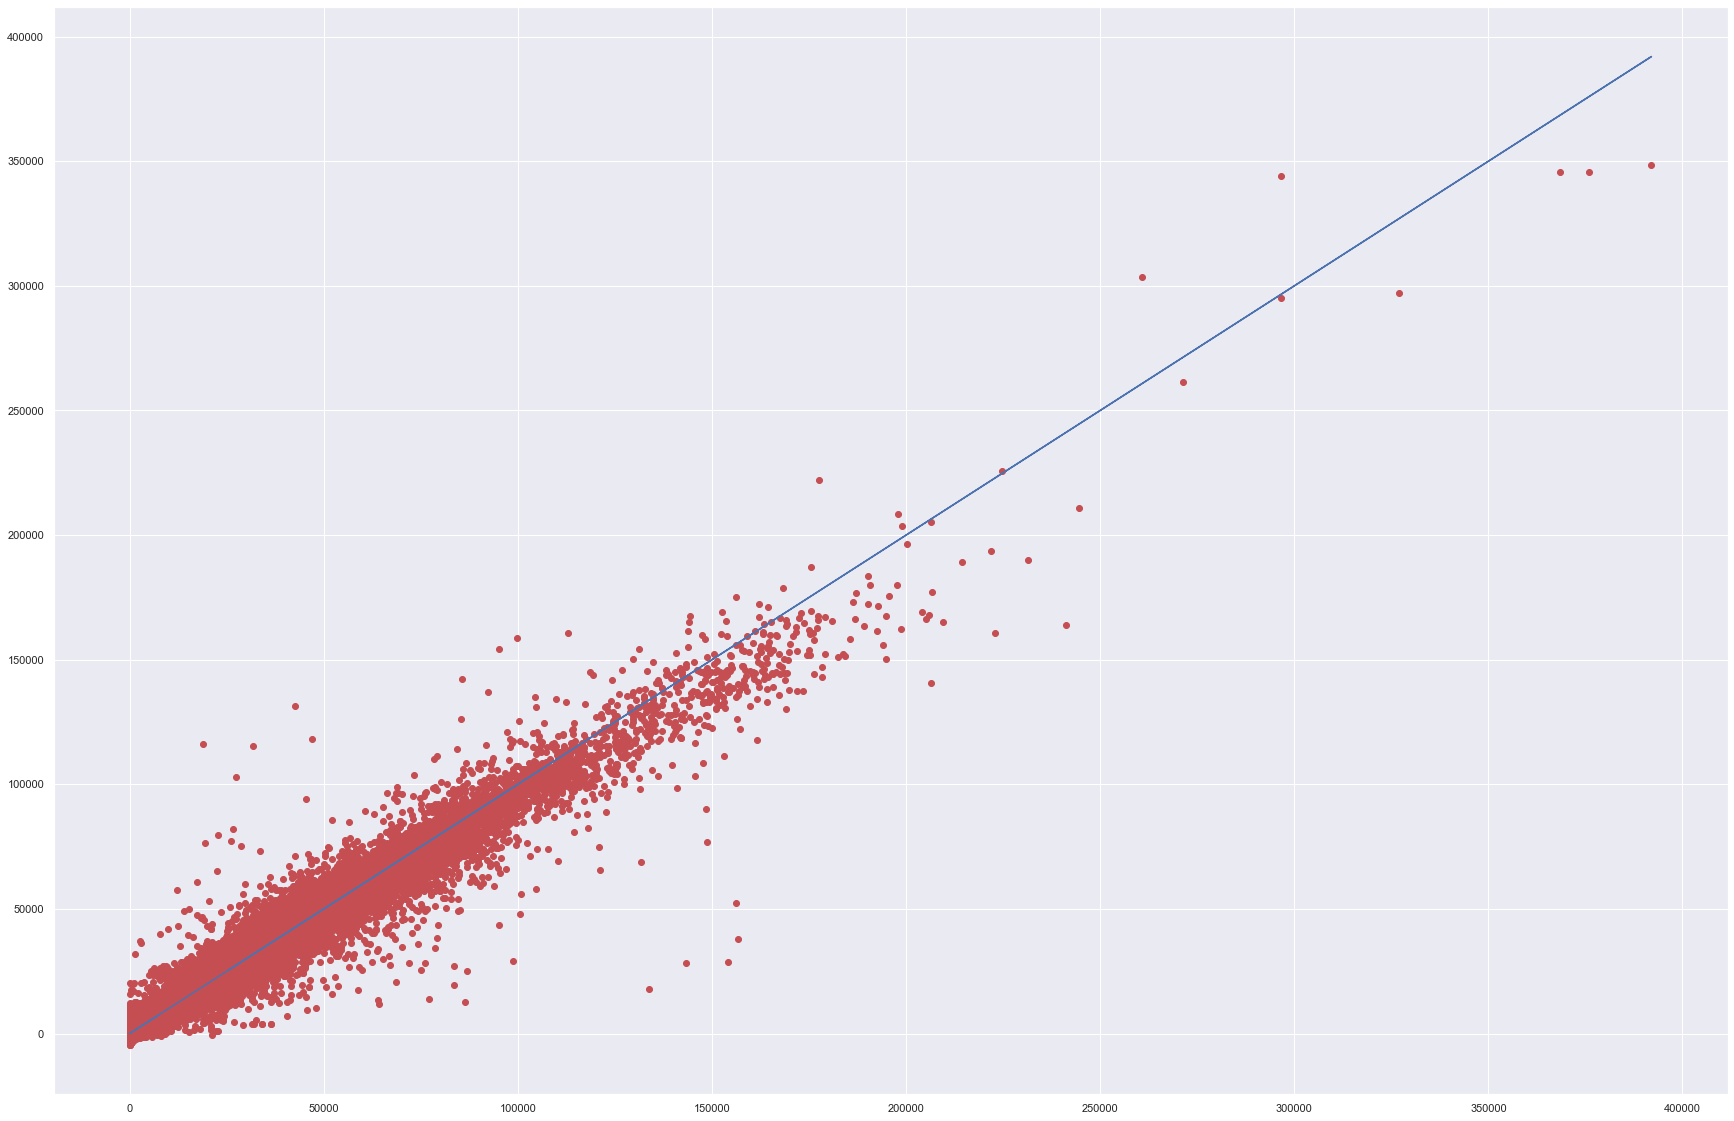

In [83]:
plt.plot(y_test, y_predict,'ro')
plt.plot(y_test, y_test,'b-')
plt.show()

In [84]:
y_vals = pd.DataFrame(y_predict, columns=['Predictions'])
y_vals['Actual'] = y_test
y_vals.head().round(0)

Predictions   Actual
0       8562.0   7576.0
1       3954.0   4204.0
2      40860.0  41856.0
3       6027.0   5069.0
4      48323.0  44752.0

In [85]:
# mean squared error
mse = np.sum((y_vals.Predictions - y_vals.Actual)**2)

# root mean squared error
# m is the number of training examples
rmse = np.sqrt(mse/m)

In [86]:
# sum of square of residuals
ssr = np.sum((y_vals.Predictions - y_vals.Actual)**2)

#  total sum of squares
sst = np.sum((y_vals.Actual - np.mean(y_vals.Actual))**2)

# R2 score
r2_score = 1 - (ssr/sst)

In [87]:
print(rmse)
print(r2_score)

4137.387476481783
0.9659868878659682


The R-squared score indicates that the percentage variable variation (total store weekly sales) that is explained by the model is approximately 96.6%.

## Linear Regression SKLearn implementation

In [88]:
train_linear = train_set.copy()
test_linear = test_set.copy()

In [89]:
X_train = train_linear.drop(['Weekly_Sales'], axis=1)
X_train = np.matrix((X_train).values)
y_train = np.matrix((train_linear['Weekly_Sales']).values)

In [90]:
y_train = y_train.T
X_train.shape, y_train.shape

((188437, 142), (188437, 1))

In [91]:
X_test = test_linear.drop(['Weekly_Sales'], axis=1)
X_test = np.matrix((X_test).values)
y_test = np.matrix((test_linear['Weekly_Sales']).values)
y_test = y_test.T

In [92]:
linear_sk = linear_model.LinearRegression()
linear_sk.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [93]:
prediction_linear_sk = linear_sk.predict(X_test)

In [94]:
linear_RMSE = np.sqrt(metrics.mean_squared_error(y_test, prediction_linear_sk))
linear_r2 = metrics.r2_score(y_test, prediction_linear_sk) 

print(linear_RMSE)
print(linear_r2)

3925.9266709888047
0.9693748413758706


## Ridge Regression

This involves the introduction of L2 regularisation in the cost function.

In [95]:
train_ridge = train_set.copy()
test_ridge = test_set.copy()

In [96]:
X_train_ridge = train_ridge.drop(['Weekly_Sales'], axis=1)
X_train_ridge = np.matrix((X_train_ridge).values)
y_train_ridge = np.matrix((train_ridge['Weekly_Sales']).values)

In [97]:
y_train_ridge = y_train_ridge.T
X_train_ridge.shape, y_train_ridge.shape

((188437, 142), (188437, 1))

In [98]:
print('Normalising features...')

X_norm_ridge, mu, sigma = featureNormalize(X_train_ridge)

Normalising features...


In [99]:
#add intercept term to X
m = len(y_train_ridge)
X_padded_ridge = np.column_stack((np.ones((m,1)),X_norm_ridge)) #add column of ones to x
theta_ridge = np.zeros((X_padded_ridge.shape[1],1))

In [100]:
# Initialize learning rate α.
alpha = 0.15

# Check the dimensions of the matrices.
X_padded_ridge.shape, y_train_ridge.shape, theta_ridge.shape

((188437, 143), (188437, 1), (143, 1))

In [101]:
# Create a function to compute cost.
def computeCostRidge(x, y, theta, lamda_coef):
    """
    Compute the cost function.
    Args:
        x: a m by n+1 matrix
        y: a m by 1 vector
        theta: a n+1 by 1 vector
    Returns:
        cost: float
    """
    m = len(x)
    l2_reg = (lamda_coef / (2*m)) * np.sum(np.square(theta[1:len(theta)]))
    cost = (np.sum(np.square((x * theta) - y)) / (2 * m)) + l2_reg
    return cost

In [102]:
# Create a function to implement gradient descent.
def gradientDescentRidge(x,y, theta, lamda_coef, iterations):
    """
    Implement gradient descent.
    Args:
        x: a m by n+1 matrix
        theta: a n+1 by 1 vector
    Return:
        theta: a n+1 by 1 vector
        J_vals: a #iterations by 1 vector
    """
    m = len(x)
    J_vals = []
    
    for i in range(iterations):
        error = (x * theta) - y
        for j in range(len(theta.flat)):
            theta.T[0, j] = theta.T[0, j] - (alpha/m) * np.sum(np.multiply(error, x[:, j]))
        J_vals.append(computeCostRidge(x, y, theta, lamda_coef))
    return (theta, J_vals)

In [103]:
lamda_coef = 1
theta_ridge, J_vals_ridge = gradientDescentRidge(X_padded_ridge, y_train_ridge, theta_ridge, lamda_coef, iterations=50)

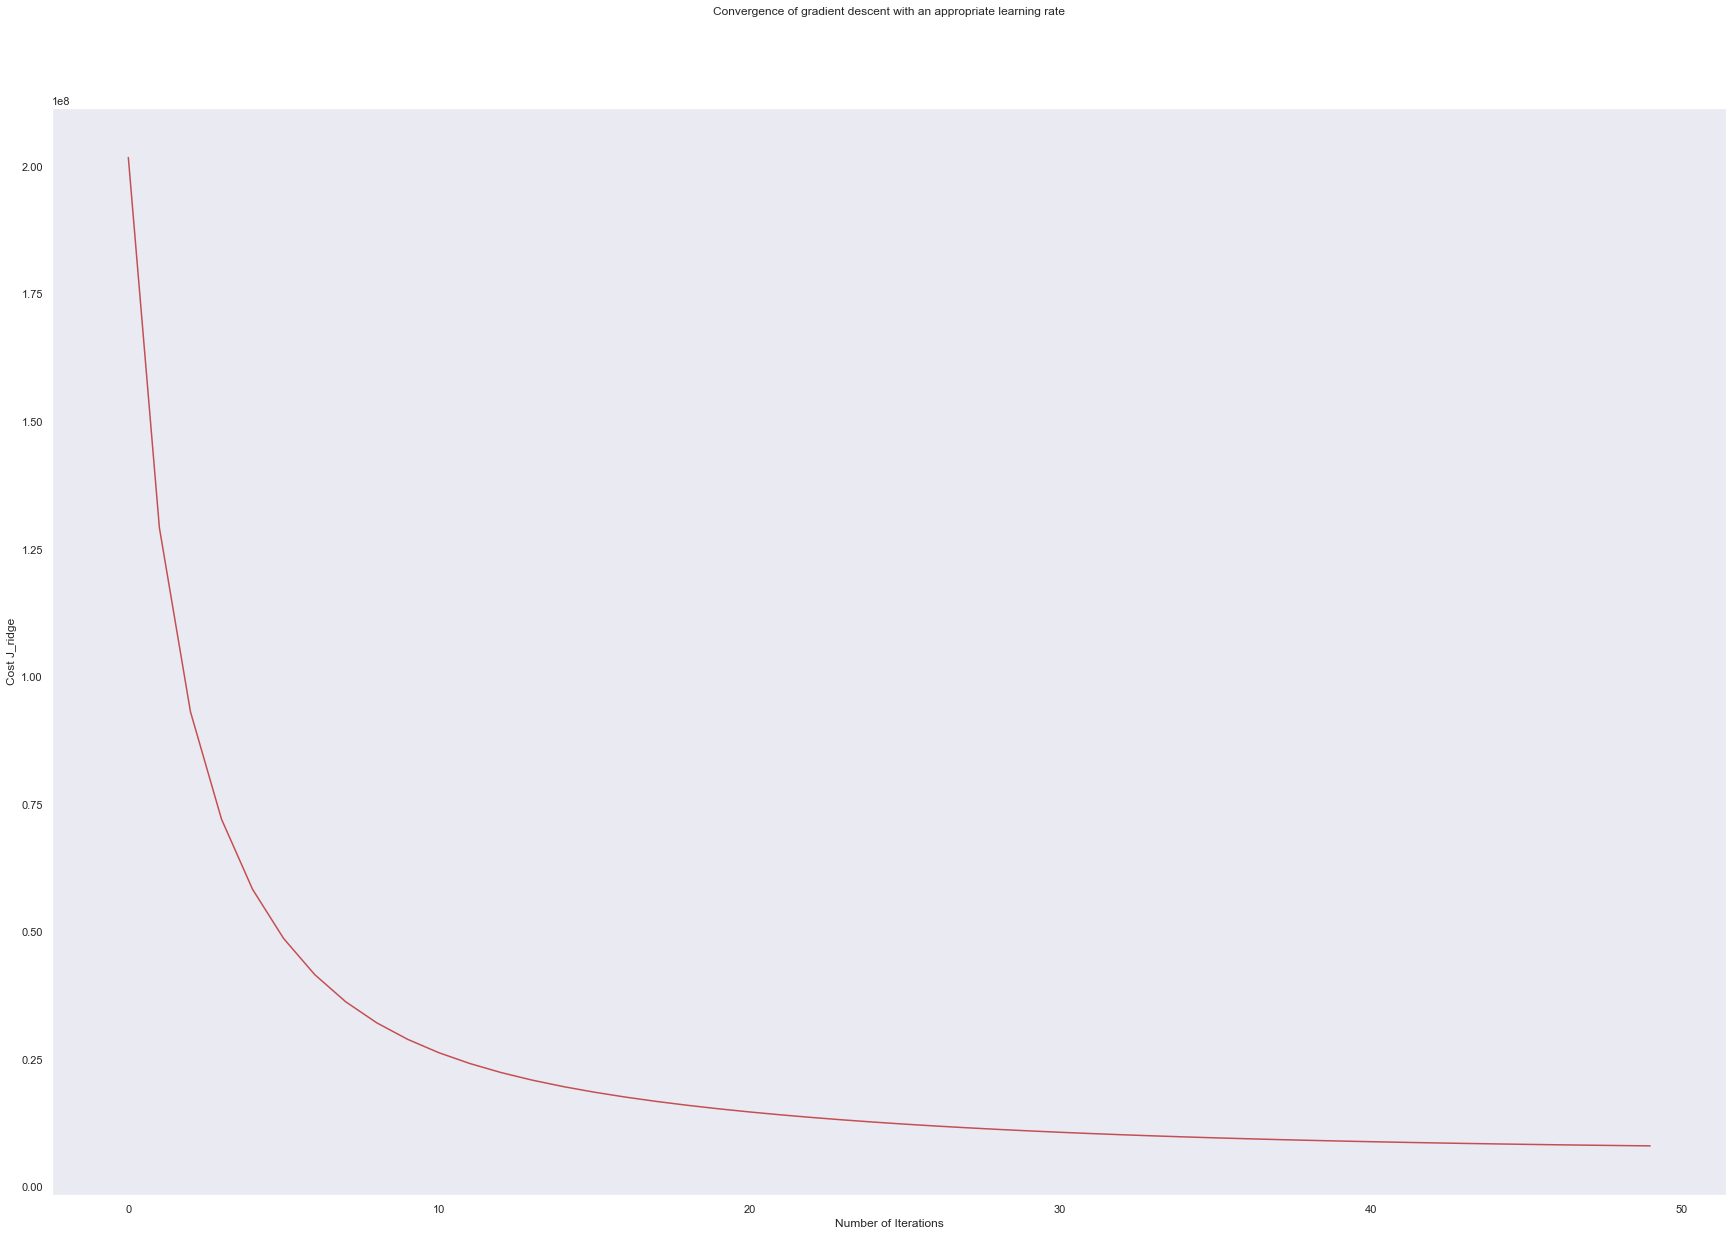

In [104]:
plt.xlabel('Number of Iterations')
plt.ylabel('Cost J_ridge')
plt.title('Convergence of gradient descent with an appropriate learning rate', y=1.08)
plt.grid()
plt.plot(range(50), J_vals_ridge, 'r')

### Testing the model

In [105]:
X_test_ridge = test_ridge.drop(['Weekly_Sales'], axis=1)
X_test_ridge = np.matrix((X_test_ridge).values)
y_test_ridge = np.matrix((test_ridge['Weekly_Sales']).values)
y_test_ridge = y_test_ridge.T

In [106]:
X_test_ridge.shape, y_test_ridge.shape

((80759, 142), (80759, 1))

In [107]:
print('Normalising features...')

X_norm_test_ridge = featureNormalizeTest(X_test_ridge, mu, sigma)

Normalising features...


In [108]:
X_norm_test_ridge.shape, y_test_ridge.shape

((80759, 142), (80759, 1))

In [109]:
#add intercept term to X
m = len(y_test_ridge)

X_padded_test_ridge = np.column_stack((np.ones((m,1)),X_norm_test_ridge)) #add column of ones to x

In [110]:
X_padded_test_ridge.shape, y_test_ridge.shape, theta_ridge.shape

((80759, 143), (80759, 1), (143, 1))

In [111]:
y_predict_ridge = X_padded_test_ridge * theta_ridge

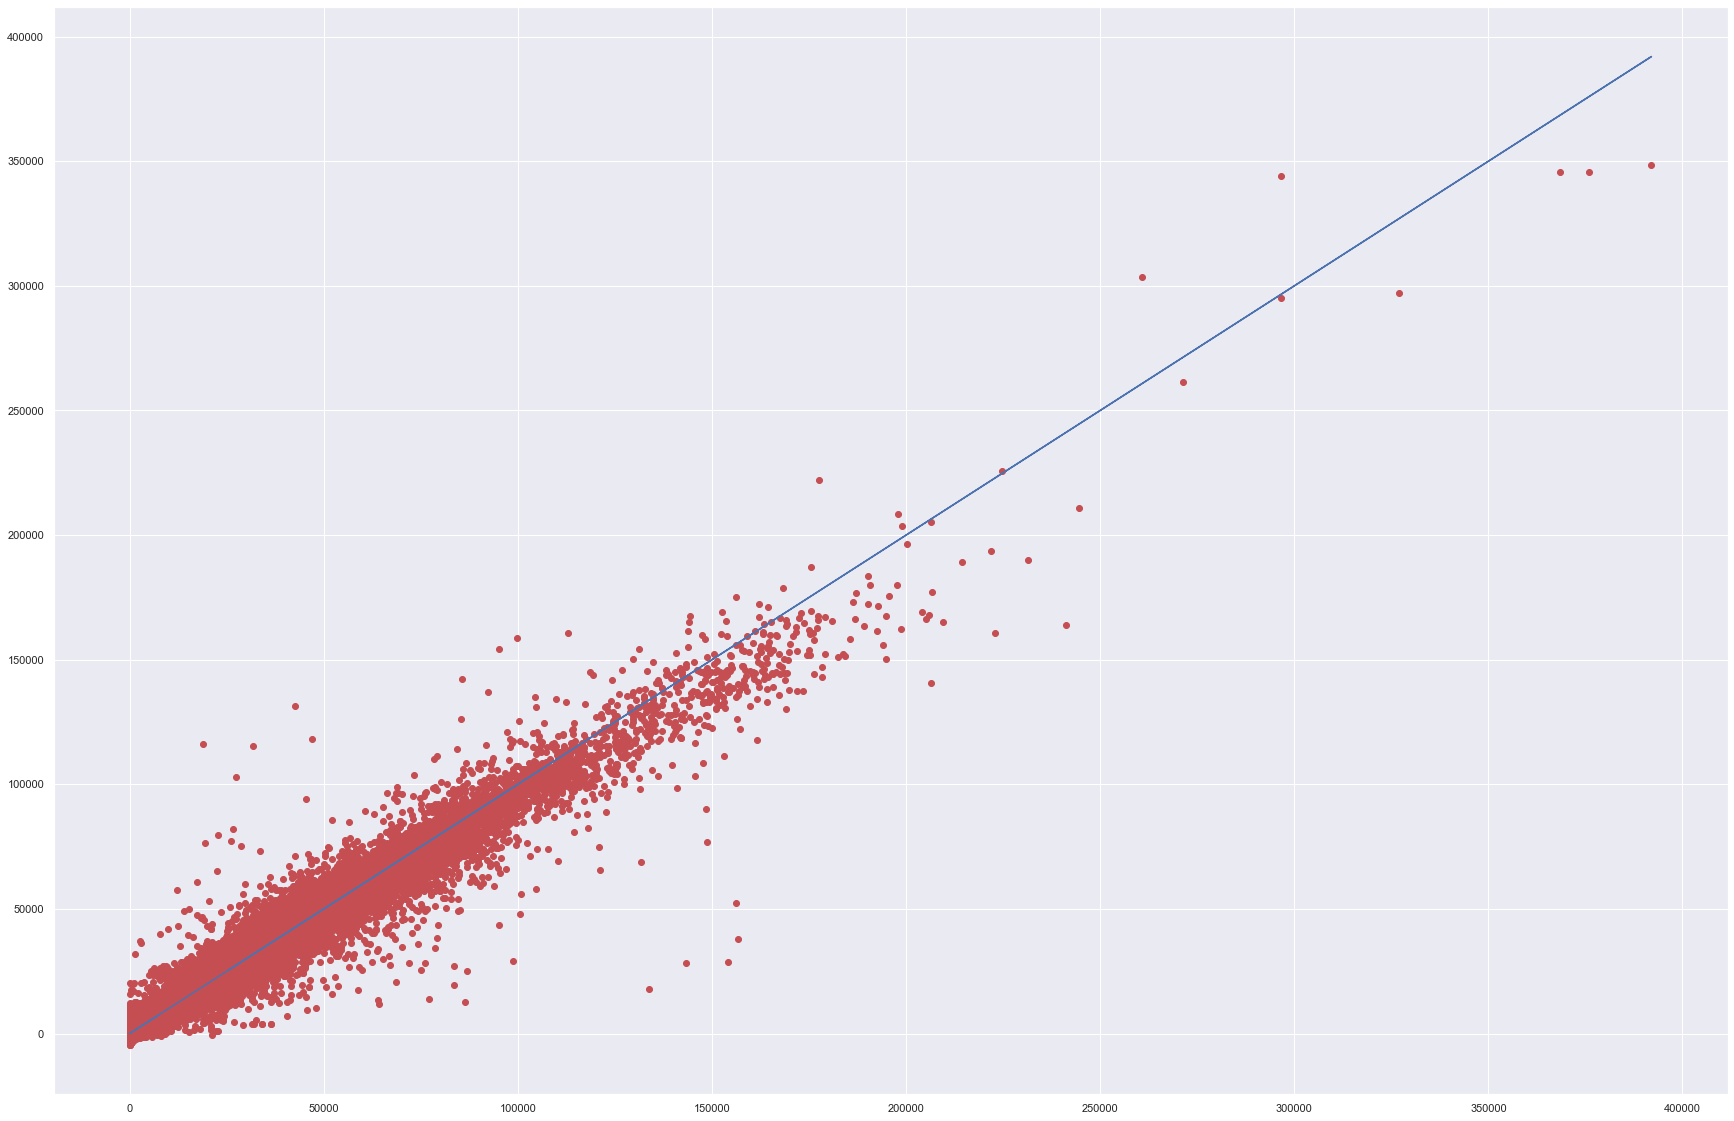

In [112]:
plt.plot(y_test_ridge, y_predict_ridge,'ro')
plt.plot(y_test_ridge, y_test_ridge,'b-')
plt.show()

In [113]:
y_vals_ridge = pd.DataFrame(y_predict_ridge, columns=['Predictions'])
y_vals_ridge['Actual'] = y_test_ridge
y_vals_ridge.head().round(0)

Predictions   Actual
0       8562.0   7576.0
1       3954.0   4204.0
2      40860.0  41856.0
3       6027.0   5069.0
4      48323.0  44752.0

In [114]:
# mean squared error
mse_ridge = np.sum((y_vals_ridge.Predictions - y_vals_ridge.Actual)**2)

# root mean squared error
# m is the number of training examples
rmse_ridge = np.sqrt(mse_ridge/m)

In [115]:
# sum of square of residuals
ssr_ridge = np.sum((y_vals_ridge.Predictions - y_vals_ridge.Actual)**2)

#  total sum of squares
sst_ridge = np.sum((y_vals_ridge.Actual - np.mean(y_vals_ridge.Actual))**2)

# R2 score
r2_score_ridge = 1 - (ssr_ridge/sst_ridge)

In [116]:
print(rmse_ridge)
print(r2_score_ridge)

4137.387476481783
0.9659868878659682


## Ridge Regression SKLearn implementation

In [117]:
train_ridge = train_set.copy()
test_ridge = test_set.copy()

In [118]:
X_train_ridge = train_ridge.drop(['Weekly_Sales'], axis=1)
X_train_ridge = np.matrix((X_train_ridge).values)
y_train_ridge = np.matrix((train_ridge['Weekly_Sales']).values)

In [119]:
y_train_ridge = y_train_ridge.T
X_train_ridge.shape, y_train_ridge.shape

((188437, 142), (188437, 1))

In [120]:
X_test_ridge = test_ridge.drop(['Weekly_Sales'], axis=1)
X_test_ridge = np.matrix((X_test_ridge).values)
y_test_ridge = np.matrix((test_ridge['Weekly_Sales']).values)
y_test_ridge = y_test_ridge.T

In [121]:
ridge_sk = linear_model.Ridge()
ridge_sk.fit(X_train_ridge, y_train_ridge)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [122]:
prediction_ridge_sk = ridge_sk.predict(X_test_ridge)

In [123]:
ridge_RMSE = np.sqrt(metrics.mean_squared_error(y_test_ridge, prediction_ridge_sk))
ridge_r2 = metrics.r2_score(y_test_ridge, prediction_ridge_sk) 

print(ridge_RMSE)
print(ridge_r2)

3925.9799648298417
0.9693740099067423


# Lasso

## From scratch

In [124]:
train_lasso = train_set.copy()
test_lasso = test_set.copy()

In [125]:
X_train_lasso = train_lasso.drop(['Weekly_Sales'], axis=1)
X_train_lasso = np.matrix((X_train_lasso).values)
y_train_lasso = np.matrix((train_lasso['Weekly_Sales']).values)

In [126]:
y_train_lasso = y_train_lasso.T
X_train_lasso.shape, y_train_lasso.shape

((188437, 142), (188437, 1))

In [127]:
print('Normalising features...')

X_norm_lasso, mu, sigma = featureNormalize(X_train_lasso)

Normalising features...


In [128]:
#add intercept term to X
m = len(y_train_lasso)
X_padded_lasso = np.column_stack((np.ones((m,1)),X_norm_lasso)) #add column of ones to x
theta_lasso = np.zeros((X_padded_lasso.shape[1],1))

In [129]:
# Initialize learning rate α.
alpha = 0.15

# Check the dimensions of the matrices.
X_padded_lasso.shape, y_train_lasso.shape, theta_lasso.shape

((188437, 143), (188437, 1), (143, 1))

In [130]:
# Create a function to compute cost.
def computeCostLasso(x, y, theta, lamda_coef):
    """
    Compute the cost function.
    Args:
        x: a m by n+1 matrix
        y: a m by 1 vector
        theta: a n+1 by 1 vector
    Returns:
        cost: float
    """
    m = len(x)
    l1_reg = (lamda_coef / (2*m)) * np.sum(np.absolute(theta[1:len(theta)]))
    cost = (np.sum(np.square((x * theta) - y)) / (2 * m)) + l1_reg
    return cost

In [131]:
# Create a function to implement gradient descent.
def gradientDescentLasso(x,y, theta, lamda_coef, iterations):
    """
    Implement gradient descent.
    Args:
        x: a m by n+1 matrix
        theta: a n+1 by 1 vector
    Return:
        theta: a n+1 by 1 vector
        J_vals: a #iterations by 1 vector
    """
    m = len(x)
    J_vals = []
    
    for i in range(iterations):
        error = (x * theta) - y
        for j in range(len(theta.flat)):
            theta.T[0, j] = theta.T[0, j] - (alpha/m) * np.sum(np.multiply(error, x[:, j]))
        J_vals.append(computeCostLasso(x, y, theta, lamda_coef))
    return (theta, J_vals)

In [132]:
lamda_coef = 1
theta_lasso, J_vals_lasso = gradientDescentLasso(X_padded_lasso, y_train_lasso, theta_lasso, lamda_coef, iterations=50)


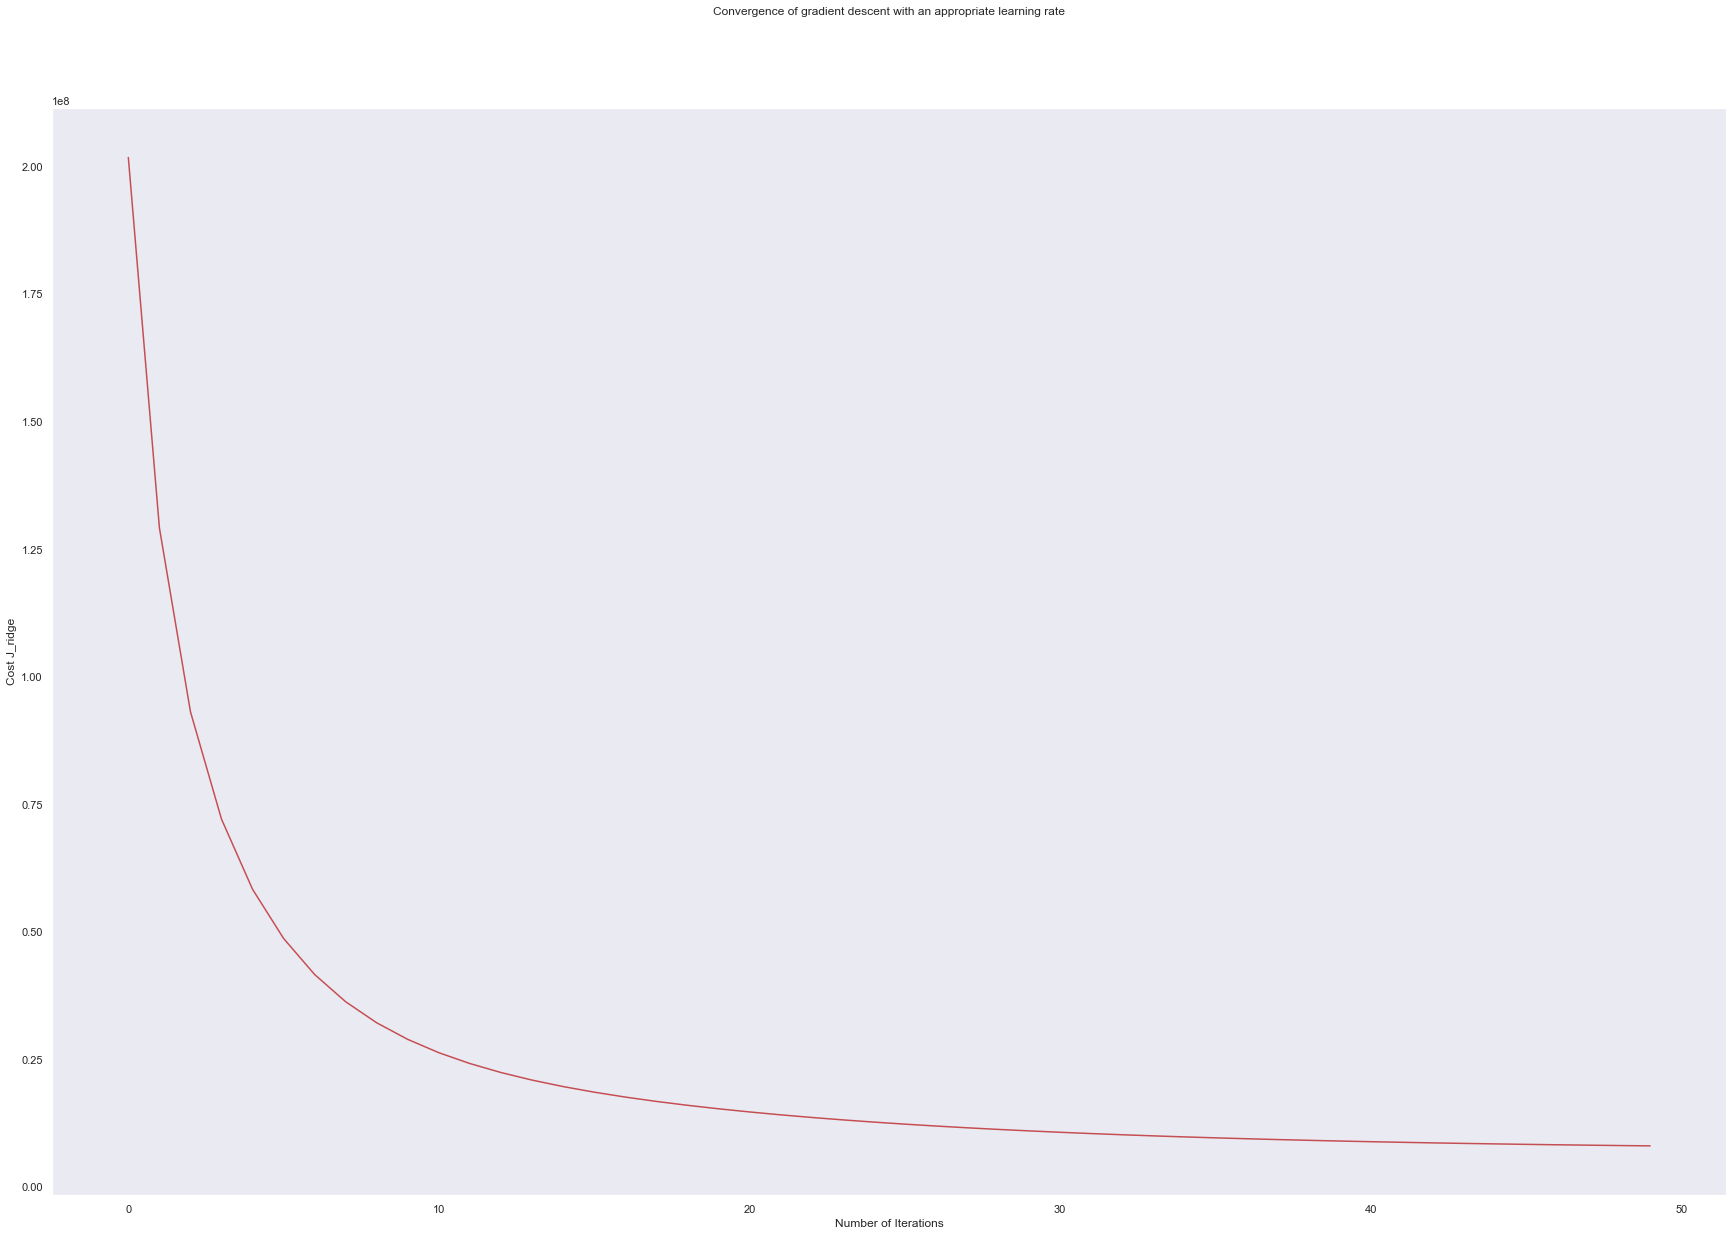

In [133]:
plt.xlabel('Number of Iterations')
plt.ylabel('Cost J_ridge')
plt.title('Convergence of gradient descent with an appropriate learning rate', y=1.08)
plt.grid()
plt.plot(range(50), J_vals_lasso, 'r')

### Testing the model

In [134]:
X_test_lasso = test_lasso.drop(['Weekly_Sales'], axis=1)
X_test_lasso = np.matrix((X_test_lasso).values)
y_test_lasso = np.matrix((test_lasso['Weekly_Sales']).values)
y_test_lasso = y_test_lasso.T

In [135]:
X_test_lasso.shape, y_test_lasso.shape

((80759, 142), (80759, 1))

In [136]:
print('Normalising features...')

X_norm_test_lasso = featureNormalizeTest(X_test_lasso, mu, sigma)

Normalising features...


In [137]:
X_norm_test_lasso.shape, y_test_lasso.shape

((80759, 142), (80759, 1))

In [138]:
#add intercept term to X
m = len(y_test_lasso)

X_padded_test_lasso = np.column_stack((np.ones((m,1)),X_norm_test_lasso)) #add column of ones to x

In [139]:
X_padded_test_lasso.shape, y_test_lasso.shape, theta_lasso.shape

((80759, 143), (80759, 1), (143, 1))

In [140]:
y_predict_lasso = X_padded_test_lasso * theta_lasso

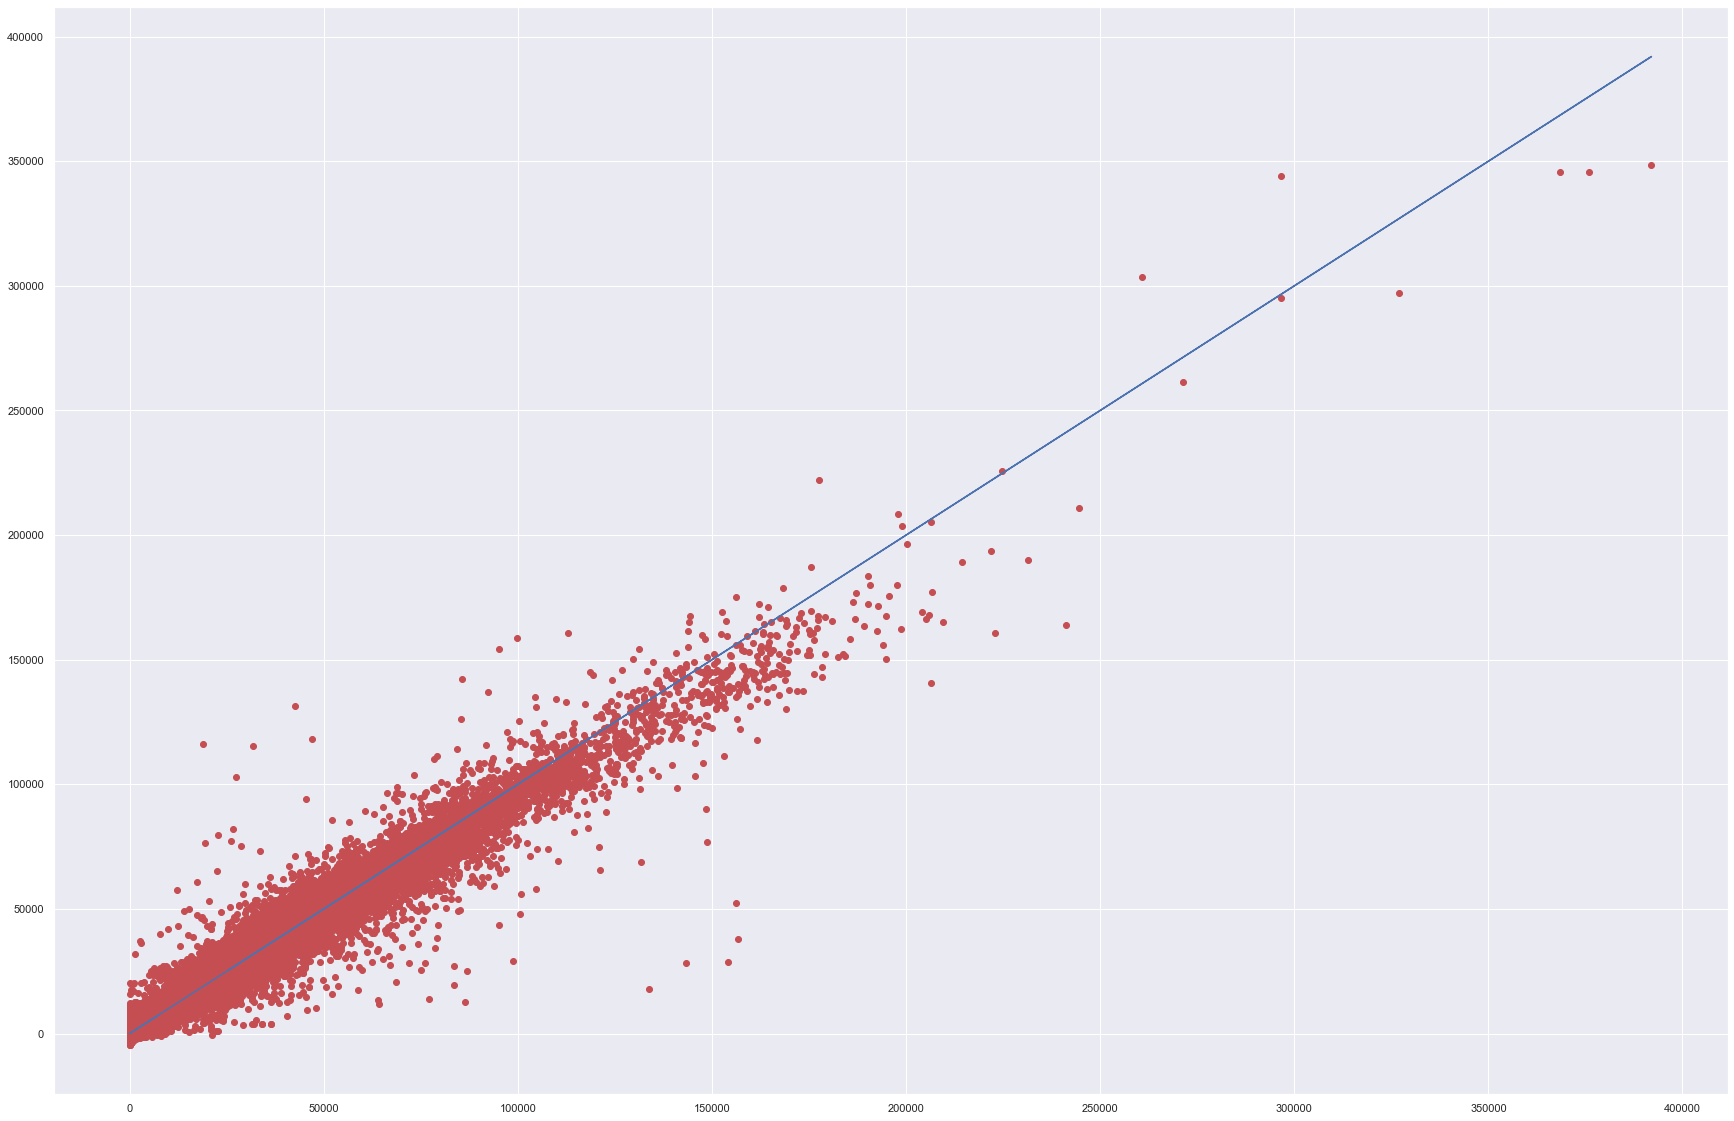

In [141]:
plt.plot(y_test_lasso, y_predict_lasso,'ro')
plt.plot(y_test_lasso, y_test_lasso,'b-')
plt.show()

In [142]:
y_vals_lasso = pd.DataFrame(y_predict_lasso, columns=['Predictions'])
y_vals_lasso['Actual'] = y_test_lasso
y_vals_lasso.head().round(0)

Predictions   Actual
0       8562.0   7576.0
1       3954.0   4204.0
2      40860.0  41856.0
3       6027.0   5069.0
4      48323.0  44752.0

In [143]:
# mean squared error
mse_lasso = np.sum((y_vals_lasso.Predictions - y_vals_lasso.Actual)**2)

# root mean squared error
# m is the number of training examples
rmse_lasso = np.sqrt(mse_lasso/m)

In [144]:
# sum of square of residuals
ssr_lasso = np.sum((y_vals_lasso.Predictions - y_vals_lasso.Actual)**2)

#  total sum of squares
sst_lasso = np.sum((y_vals_lasso.Actual - np.mean(y_vals_lasso.Actual))**2)

# R2 score
r2_score_lasso = 1 - (ssr_lasso/sst_lasso)

In [145]:
print(rmse_lasso)
print(r2_score_lasso)

4137.387476481783
0.9659868878659682


## Lasso SKLearn implementation

In [146]:
train_lasso = train_set.copy()
test_lasso = test_set.copy()

In [147]:
X_train_lasso = train_lasso.drop(['Weekly_Sales'], axis=1)
X_train_lasso = np.matrix((X_train_lasso).values)
y_train_lasso = np.matrix((train_lasso['Weekly_Sales']).values)

In [148]:
y_train_lasso = y_train_lasso.T
X_train_lasso.shape, y_train_lasso.shape

((188437, 142), (188437, 1))

In [149]:
X_test_lasso = test_lasso.drop(['Weekly_Sales'], axis=1)
X_test_lasso = np.matrix((X_test_lasso).values)
y_test_lasso = np.matrix((test_lasso['Weekly_Sales']).values)
y_test_lasso = y_test_lasso.T

In [150]:
lasso_sk = linear_model.Lasso(alpha=0.1)
lasso_sk.fit(X_train_lasso, y_train_lasso)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [151]:
predictions_lasso_sk = lasso_sk.predict(X_test_lasso)

In [152]:
lasso_RMSE = np.sqrt(metrics.mean_squared_error(y_test_lasso, predictions_lasso_sk))
lasso_r2 = metrics.r2_score(y_test_lasso, predictions_lasso_sk) 

print(lasso_RMSE)
print(lasso_r2)

3926.977635332551
0.9693584425684058


## Elastic Net

Combination of L1 and L2 regularisation

In [153]:
train_elastic = train_set.copy()
test_elastic = test_set.copy()

In [154]:
X_train_elastic = train_elastic.drop(['Weekly_Sales'], axis=1)
X_train_elastic = np.matrix((X_train_elastic).values)
y_train_elastic = np.matrix((train_elastic['Weekly_Sales']).values)

In [155]:
y_train_elastic = y_train_elastic.T
X_train_elastic.shape, y_train_elastic.shape

((188437, 142), (188437, 1))

In [156]:
print('Normalising features...')

X_norm_elastic, mu, sigma = featureNormalize(X_train_elastic)

Normalising features...


In [157]:
#add intercept term to X
m = len(y_train_elastic)
X_padded_elastic = np.column_stack((np.ones((m,1)),X_norm_elastic)) #add column of ones to x
theta_elastic = np.zeros((X_padded_elastic.shape[1],1))

In [158]:
# Create a function to compute cost.
def computeCostElastic(x, y, theta, alpha, lamda_coef):
    """
    Compute the cost function.
    Args:
        x: a m by n+1 matrix
        y: a m by 1 vector
        theta: a n+1 by 1 vector
    Returns:
        cost: float
    """
    m = len(x)
    l1_reg = alpha * np.sum(np.absolute(theta[1:len(theta)]))
    l2_reg = ((1 - alpha)/2) * np.sum(np.square(theta[1:len(theta)]))
    tot_reg = (lamda_coef / (2*m)) * (l2_reg + l1_reg)
    cost = (np.sum(np.square((x * theta) - y)) / (2 * m)) + tot_reg
    return cost

In [159]:
# Create a function to implement gradient descent.
def gradientDescentElastic(x,y, theta, alpha, lamda_coef, iterations):
    """
    Implement gradient descent.
    Args:
        x: a m by n+1 matrix
        theta: a n+1 by 1 vector
    Return:
        theta: a n+1 by 1 vector
        J_vals: a #iterations by 1 vector
    """
    m = len(x)
    J_vals = []
    
    for i in range(iterations):
        error = (x * theta) - y
        for j in range(len(theta.flat)):
            theta.T[0, j] = theta.T[0, j] - (alpha/m) * np.sum(np.multiply(error, x[:, j]))
        J_vals.append(computeCostElastic(x, y, theta, alpha, lamda_coef))
    return (theta, J_vals)

In [160]:
lamda_coef = 1
alpha = 0.5
theta_elastic, J_vals_elastic = gradientDescentElastic(X_padded_elastic, y_train_elastic, theta_elastic, alpha, lamda_coef, iterations=50)


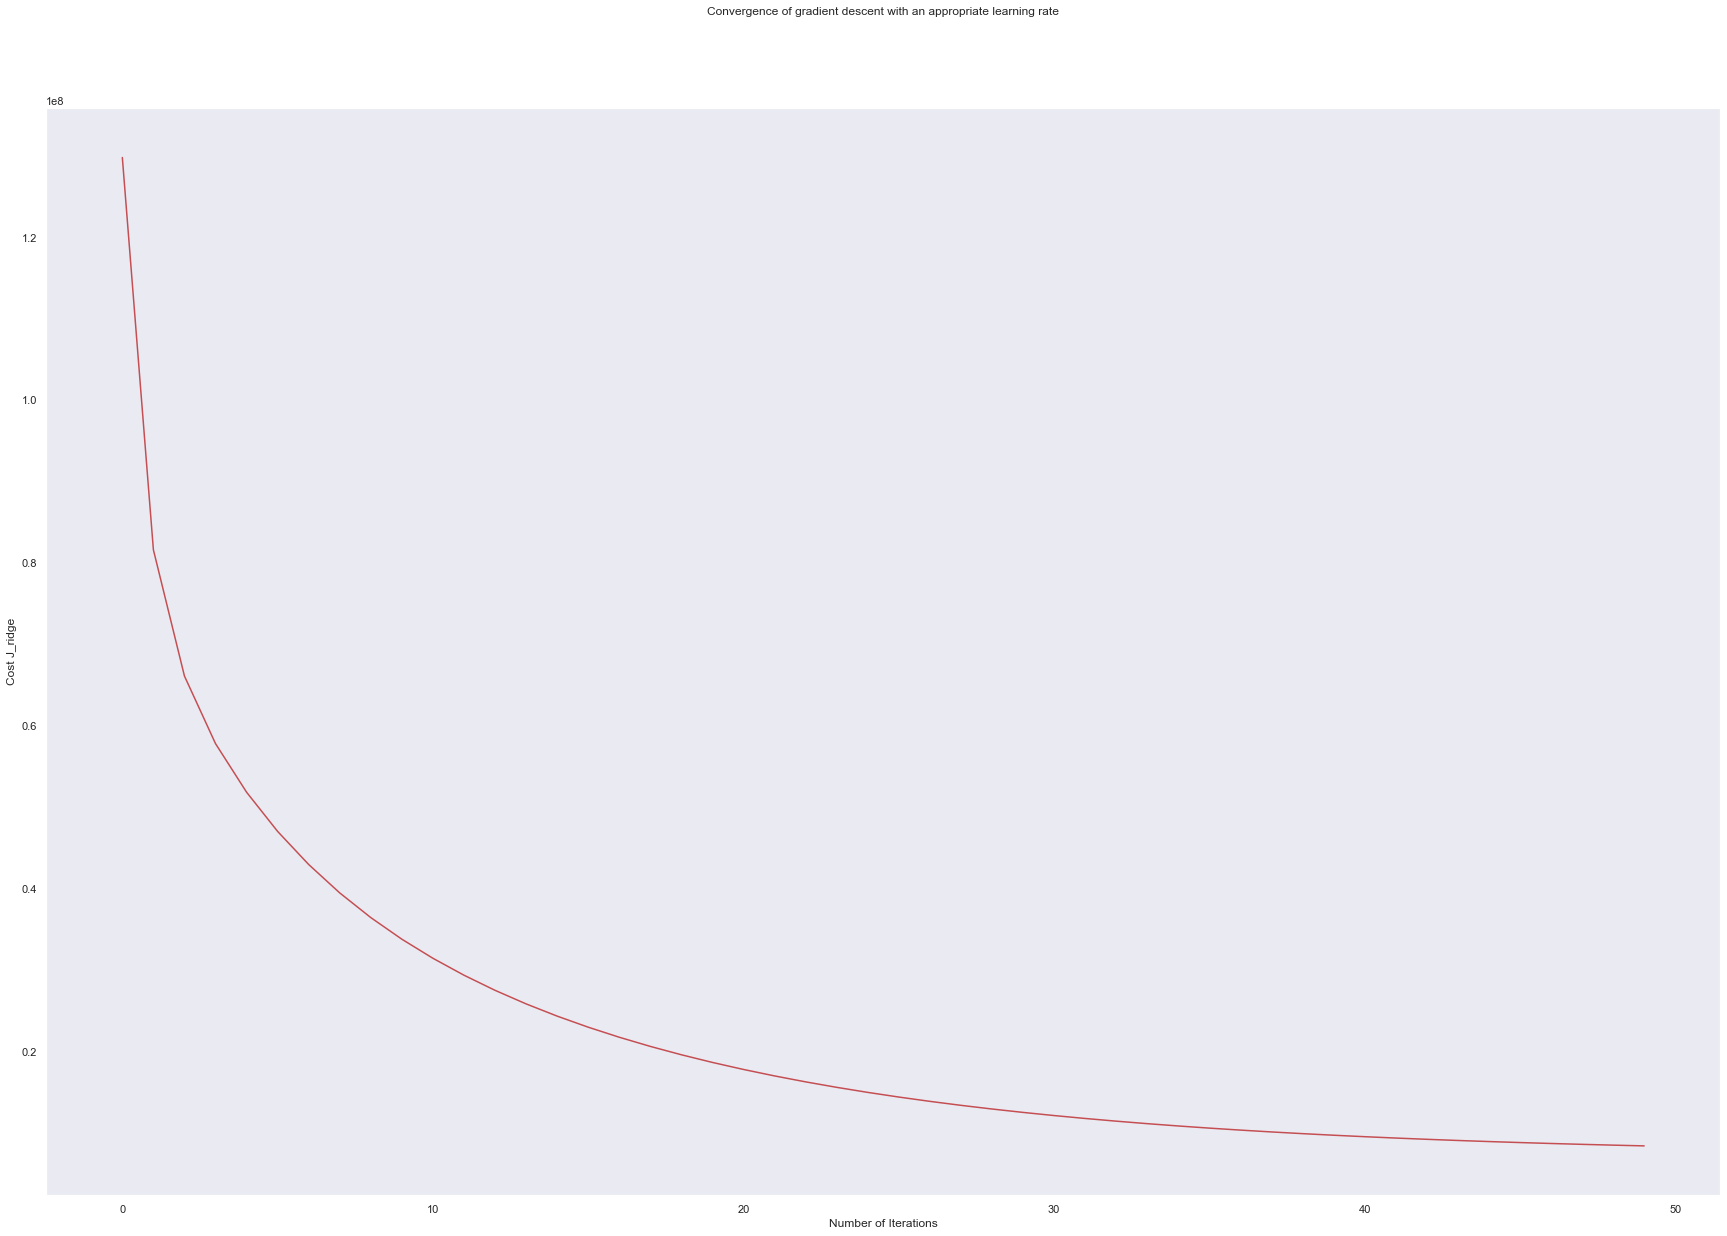

In [161]:
plt.xlabel('Number of Iterations')
plt.ylabel('Cost J_ridge')
plt.title('Convergence of gradient descent with an appropriate learning rate', y=1.08)
plt.grid()
plt.plot(range(50), J_vals_elastic, 'r')

### Testing the model

In [162]:
X_test_elastic = test_elastic.drop(['Weekly_Sales'], axis=1)
X_test_elastic = np.matrix((X_test_elastic).values)
y_test_elastic = np.matrix((test_elastic['Weekly_Sales']).values)
y_test_elastic = y_test_elastic.T

In [163]:
X_test_elastic.shape, y_test_elastic.shape

((80759, 142), (80759, 1))

In [164]:
print('Normalising features...')

X_norm_test_elastic = featureNormalizeTest(X_test_elastic, mu, sigma)

Normalising features...


In [165]:
X_norm_test_elastic.shape, y_test_elastic.shape

((80759, 142), (80759, 1))

In [166]:
#add intercept term to X
m = len(y_test_elastic)

X_padded_test_elastic = np.column_stack((np.ones((m,1)),X_norm_test_elastic)) #add column of ones to x

In [167]:
X_padded_test_elastic.shape, y_test_elastic.shape, theta_elastic.shape

((80759, 143), (80759, 1), (143, 1))

In [168]:
y_predict_elastic = X_padded_test_elastic * theta_elastic

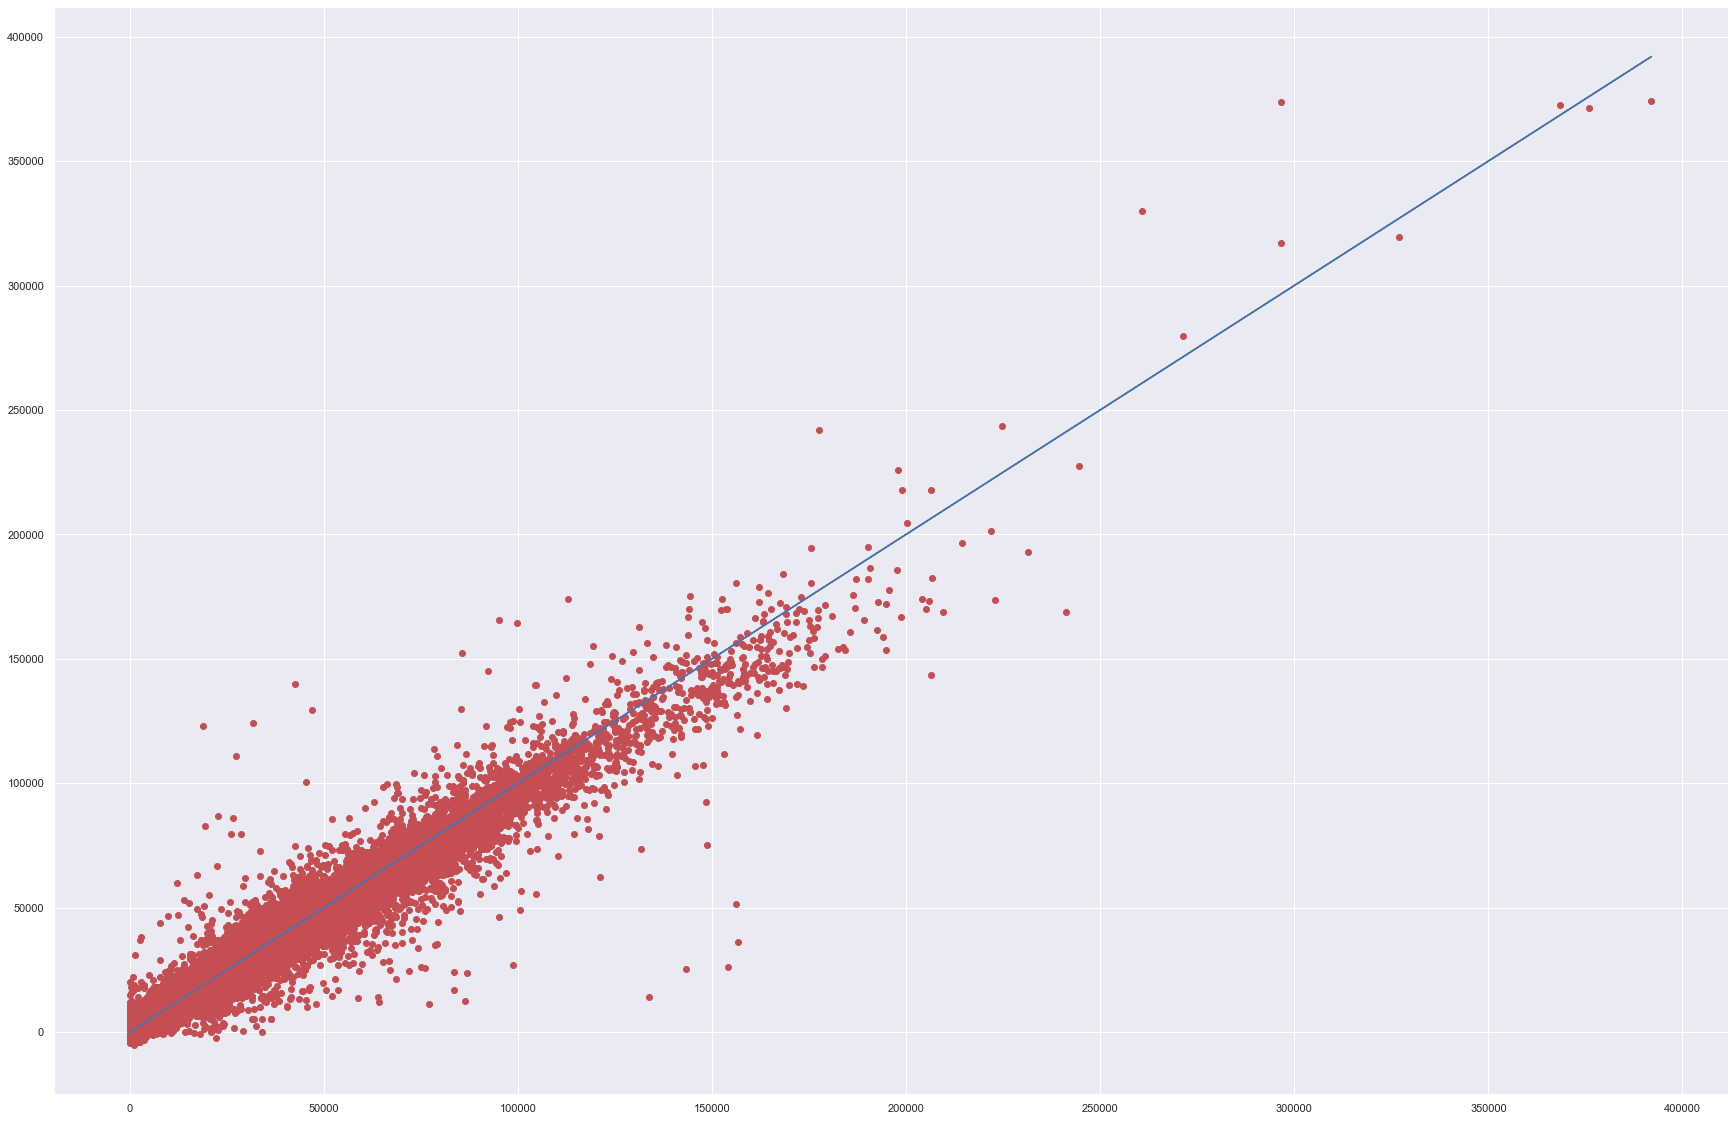

In [169]:
plt.plot(y_test_elastic, y_predict_elastic,'ro')
plt.plot(y_test_elastic, y_test_elastic,'b-')
plt.show()

In [170]:
y_vals_elastic = pd.DataFrame(y_predict_elastic, columns=['Predictions'])
y_vals_elastic['Actual'] = y_test_elastic
y_vals_elastic.head().round(0)

Predictions   Actual
0       8097.0   7576.0
1       3127.0   4204.0
2      39994.0  41856.0
3       3679.0   5069.0
4      49217.0  44752.0

In [171]:
# mean squared error
mse_elastic = np.sum((y_vals_elastic.Predictions - y_vals_elastic.Actual)**2)

# root mean squared error
# m is the number of training examples
rmse_elastic = np.sqrt(mse_elastic/m)

In [172]:
# sum of square of residuals
ssr_elastic = np.sum((y_vals_elastic.Predictions - y_vals_elastic.Actual)**2)

#  total sum of squares
sst_elastic = np.sum((y_vals_elastic.Actual - np.mean(y_vals_elastic.Actual))**2)

# R2 score
r2_score_elastic = 1 - (ssr_elastic/sst_elastic)

In [173]:
print(rmse_elastic)
print(r2_score_elastic)

4215.770766124629
0.9646859151912964


## Elastic Net SKLearn implementation

In [174]:
train_elastic = train_set.copy()
test_elastic = test_set.copy()

In [175]:
X_train_elastic = train_elastic.drop(['Weekly_Sales'], axis=1)
X_train_elastic = np.matrix((X_train_elastic).values)
y_train_elastic = np.matrix((train_elastic['Weekly_Sales']).values)

In [176]:
y_train_elastic = y_train_elastic.T
X_train_elastic.shape, y_train_elastic.shape

((188437, 142), (188437, 1))

In [177]:
X_test_elastic = test_elastic.drop(['Weekly_Sales'], axis=1)
X_test_elastic = np.matrix((X_test_elastic).values)
y_test_elastic = np.matrix((test_elastic['Weekly_Sales']).values)
y_test_elastic = y_test_elastic.T

In [178]:
elastic_sk = linear_model.ElasticNet(alpha=0.001)
elastic_sk.fit(X_train_elastic, y_train_elastic)

ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [179]:
predictions_elastic_sk = elastic_sk.predict(X_test_elastic)

In [180]:
elastic_RMSE = np.sqrt(metrics.mean_squared_error(y_test_elastic, predictions_elastic_sk))
elastic_r2 = metrics.r2_score(y_test_elastic, predictions_elastic_sk) 

print(elastic_RMSE)
print(elastic_r2)

3928.15051636024
0.9693401362414069


These scores can definitely be improved. However, the purpose of this notebook was only to demonstrate Linear Regression algorithms from scratch.